# IERG 5350 Assignment 4: Advanced Algorithms for Continuous Control in RL

### Welcome to assignment 4 of our RL course!
*2020-2021 Term 1, IERG 5350: Reinforcement Learning. Department of Information Engineering, The Chinese University of Hong Kong. Course Instructor: Professor ZHOU Bolei. Assignment author: PENG Zhenghao, SUN Hao, ZHAN Xiaohang.*


| Student Name | Student ID |
| :----: | :----: |
| BAI Fan | 1155149235 |

------


In this assignment, we will implement a system of RL that allows us to train and evaluate RL agents formally and efficiently.

In this notebook, you will go through the following components of the whole system:
- Preparation: Colab, and Environment
- Section 1: Training with algorithm PPO
- Section 2: Training with algorithm DDPG
- Section 3: Training with algorithm TD3
- Section 4: Transfer your PPO/ DDPG/ TD3 to another task: Four-Solution-Maze

The author of this assignment is SUN, Hao (sh018 AT ie.cuhk.edu.hk).

# Colab

### Introduction to Google Colab: 
From now on, our assignment as well as the final project will be based on the Google Colab, where you can apply for free GPU resources to accelerate the learning of your RL models. 

Here are some resources as intro to the Colab.

- YouTube Video: https://www.youtube.com/watch?v=inN8seMm7UI
- Colab Intro: https://colab.research.google.com/notebooks/intro.ipynb
(you may need to login with your google account)




# Gym Continuous Control Tasks

### Introduction to the Gym Continuous Control Envirionments

In the last assignment, you have already used the gym[atari] benchmarks, where the action space is discrete so that normal approach is value-based methods e.g., DQN.

In this assignment, we will try to implement three prevailing RL algorithms for continuous control tasks, namely the PPO(https://arxiv.org/abs/1707.06347), DDPG(https://arxiv.org/abs/1509.02971) and TD3(https://arxiv.org/abs/1802.09477).

We will now begin with a gym environment for continuous control,

The Pendulum-v0






In [52]:
import gym
ENV_NAME = "Pendulum-v0"
env = gym.make(ENV_NAME)
state = env.reset()
print('the state space is like', state)
print('the max and min action is: ',env.action_space.high,env.action_space.low)

'''so that you may need to use action value re-size if you want to use the tanh activation functions'''

the state space is like [0.74556654 0.6664312  0.4888417 ]
the max and min action is:  [2.] [-2.]


'so that you may need to use action value re-size if you want to use the tanh activation functions'

# PPO 

The Proximal Policy Optimization Algorithms is the most prevailing on-policy learning method. Although its sample efficiency is not as high as the off-policy methods, the PPO is relatively easy to implement and the learning is much more stable than off-policy methods. Whenever you have a task you want to try whether RL works, you may try to run a PPO agent at first. It is worth mentioning even the most challenging game, the StarCraftII agent AlphaStar is trained based on PPO (with lots of improvements, ofcourse).


## TODOs for You
The ppo has the benfitsof trust region policy optimization (TRPO) but is much simpler to implement, and with some implementation engeneering, the sample complexity of TRPO is further improved.

The key idea of PPO optimization is *Not Optimize the Policy Too Much in a Certain Step*, which follows the key insight of the method of TRPO.

In TRPO, the optimization objective of policy is to learn a policy such that 

$$\max_\theta \hat{\mathbb{E}}_t [\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}\hat{A}_t]$$

subject to 

$$\hat{\mathbb{E}}_t[KL[\pi_{\theta_{old}}(\cdot|s_t),\pi_\theta(\cdot|s_t)]] \le \delta$$

where $\hat{A}$ denotes the advantage function, rather than optimize the objective function of 

$$L^{PG}(\theta) = \hat{\mathbb{E}}_t[\log \pi_\theta(a_t|s_t)\hat{A}_t]$$

in the normal policy gradint methods.

The PPO proposed two alternative approaches to solve the constrained optimization above, namely the Clipped Surrogated Objective and the Adaptive KL penalty Coefficient. The former one is more generally used in practice as it's more convenient to implement, more efficient and owns stable performance.

The Clipped Surrogated Objective approach replace the surrogate objective

$$L^{CPI}(\theta) = \hat{\mathbb{E}}_t[\frac{\pi_\theta(a_t|s_t)}{\pi_{\theta_{old}}(a_t|s_t)}\hat{A}_t] = \hat{\mathbb{E}}_t[r_t(\theta)\hat{A}_t]$$

of TRPO (CPI: Conservative Policy Iteration) by 

$$L^{CLIP}(\theta) = \hat{\mathbb{E}}_t[\min(r_t(\theta)\hat{A}_t,clip(r_t(\theta),1-\epsilon, 1+\epsilon)\hat{A}_t)]$$

You can check that $L^{CLIP}(\theta) = L^{CPI}(\theta)$ around the old policy parameter $\theta_{old}$, i.e., when r = 1.

## TODOs here:

In this section, your task is to finish the code of a PPO algorithm and evaluate its performance in the Pendulum-v0 environment.

Specifically, you need to
- Q1. finish building up the ActorCritic ''\__init__'' function, i.e., build up the neural network.
- Q2. finish the foward function, in this part, there are two functions need to finish: the \_forward_actor function and the \_forward_critic function
- Q3. finish the select_action function, which is called during interacting with the environment, so that you may need to return an action as well as the (log-)probability of getting that action for future optimization
- Q4. finish the optimization steps for your PPO agent, that means you need to build up the surrogate loss through your saved tuples in previous episodes and optimize it with current network parameters.
- Q5. finally, you may need to optimize some of the hyper-parameters to have a better task performance. 

In [82]:
# You need not to rivese this unless you want to try other hyper-parameter settings
# in which case you may revise the default values of class args()
from IPython import display
import torch
import torch.nn as nn
import torch.optim as opt
from torch import Tensor
from torch.autograd import Variable
from collections import namedtuple
from itertools import count
import torch.nn.functional as F
import matplotlib.pyplot as plt
from os.path import join as joindir
from os import makedirs as mkdir
import pandas as pd
import numpy as np
import argparse
import datetime
import math
import random

Transition = namedtuple('Transition', ('state', 'value', 'action', 'logproba', 'mask', 'next_state', 'reward'))
env = gym.make(ENV_NAME)
env.reset()

EPS = 1e-10 # you may need this tiny value somewhere, and think about why?
RESULT_DIR = 'Result_PPO'
mkdir(RESULT_DIR, exist_ok=True)
mkdir(ENV_NAME.split('-')[0]+'/CheckPoints', exist_ok=True)
mkdir(ENV_NAME.split('-')[0]+'/Rwds', exist_ok=True)
rwds = []
rwds_history = []

class args(object):
    hid_num = 256
    drop_prob = 0.1
    env_name = ENV_NAME
    seed = 1
    num_episode = 300
    batch_size = 5120
    max_step_per_round = 2000
    gamma = 0.99
    lamda = 0.95
    log_num_episode = 1
    num_epoch = 10
    minibatch_size = 512
    clip = 0.2
    loss_coeff_value = 0.5
    loss_coeff_entropy = 0.0
    lr = 3e-4
    num_parallel_run = 1
    # tricks
    schedule_adam = 'linear'
    schedule_clip = 'linear'
    layer_norm = True
    state_norm = True
    advantage_norm = True
    lossvalue_norm = True

In [83]:
# You need not to rivese this, these classes are used for normalization
class RunningStat(object):
    def __init__(self, shape):
        self._n = 0
        self._M = np.zeros(shape)
        self._S = np.zeros(shape)

    def push(self, x):
        x = np.asarray(x)
        assert x.shape == self._M.shape
        self._n += 1
        if self._n == 1:
            self._M[...] = x
        else:
            oldM = self._M.copy()
            self._M[...] = oldM + (x - oldM) / self._n
            self._S[...] = self._S + (x - oldM) * (x - self._M)

    @property
    def n(self):
        return self._n

    @property
    def mean(self):
        return self._M

    @property
    def var(self):
        return self._S / (self._n - 1) if self._n > 1 else np.square(self._M)

    @property
    def std(self):
        return np.sqrt(self.var)

    @property
    def shape(self):
        return self._M.shape


class ZFilter:
    """
    y = (x-mean)/std
    using running estimates of mean,std
    """

    def __init__(self, shape, demean=True, destd=True, clip=10.0):
        self.demean = demean
        self.destd = destd
        self.clip = clip

        self.rs = RunningStat(shape)

    def __call__(self, x, update=True):
        if update: self.rs.push(x)
        if self.demean:
            x = x - self.rs.mean
        if self.destd:
            x = x / (self.rs.std + 1e-8)
        if self.clip:
            x = np.clip(x, -self.clip, self.clip)
        return x

    def output_shape(self, input_space):
        return input_space.shape

In [89]:
# Here, you need to finish the first 5 tasks.
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, layer_norm=True):
        super(ActorCritic, self).__init__()
        '''
        Q1:
        Initialize your networks
        '''
        self.actor_fc1 = nn.Linear(3, args.hid_num)
        self.actor_fc2 = nn.Linear(args.hid_num, args.hid_num)
        self.actor_fc3 = nn.Linear(args.hid_num, 1)
        self.actor_logstd = nn.Parameter(torch.zeros(1, num_outputs))
        #self.actor_logstd = nn.Linear(args.hid_num, 1)


        self.critic_fc1 = nn.Linear(3, args.hid_num)
        self.critic_fc2 = nn.Linear(args.hid_num, args.hid_num)
        self.critic_fc3 = nn.Linear(args.hid_num, 1)

        if layer_norm:
            self.layer_norm(self.actor_fc1, std=1.0)
            self.layer_norm(self.actor_fc2, std=1.0)
            self.layer_norm(self.actor_fc3, std=0.01)

            self.layer_norm(self.critic_fc1, std=1.0)
            self.layer_norm(self.critic_fc2, std=1.0)
            self.layer_norm(self.critic_fc3, std=1.0)

    @staticmethod
    def layer_norm(layer, std=1.0, bias_const=0.0):
        torch.nn.init.orthogonal_(layer.weight, std)
        torch.nn.init.constant_(layer.bias, bias_const)

    def forward(self, states):
        """
        Q2.1:
        run policy network (actor) as well as value network (critic)
        :param states: a tensor represents states
        :return: 3 Tensor2
        your _forward_actor() function should return both the mean value of action and the log-standard deviation of the action
        """

        action_mean, action_logstd = self._forward_actor(states)
        critic_value = self._forward_critic(states)
        return action_mean, action_logstd, critic_value

    def _forward_actor(self, states):
        '''
        Q2.2:
        build something like 
        x = activation (actor_fc(state))
        the logstd output has already been provided
        '''
        x1 = F.relu(self.actor_fc1(states))
        x2 = F.relu(self.actor_fc2(x1))
        action_mean = 2.0 * F.tanh(self.actor_fc3(x2))
        action_logstd = self.actor_logstd.expand_as(action_mean)
        #action_logstd = F.softplus(self.actor_logstd(x2))
        return action_mean, action_logstd

    def _forward_critic(self, states):
        '''
        Q2.3:
        build something like 
        x = activation (critic_fc(state))'''
        c1 = F.relu(self.critic_fc1(states))
        c2 = F.relu(self.critic_fc2(c1))
        critic_value = self.critic_fc3(c2)
        return critic_value

    def select_action(self, action_mean, action_logstd, return_logproba=True):
        """
        Q3.1:
        given mean and std, sample an action from normal(mean, std)
        also returns probability of the given chosen
        """
        action_std = torch.exp(action_logstd)
        action = torch.normal(action_mean, action_std)
        if return_logproba:
            logproba = self._normal_logproba(action, action_mean, action_logstd, action_std)
        
        return action, logproba

    @staticmethod
    def _normal_logproba(x, mean, logstd, std=None):
        '''
        Q3.2:
        given a mean and logstd of a gaussian,
        calculate the log-probability of a given x'''
        
        if std is None:
            std = torch.exp(logstd)

        std_sq = std.pow(2)
        logproba = - 0.5 * math.log(2 * math.pi) - logstd - (x - mean).pow(2) / (2 * std_sq)

        return logproba.sum(1)


    def get_logproba(self, states, actions):
        """
        return probability of chosen the given actions under corresponding states of current network
        :param states: Tensor
        :param actions: Tensor
        """
        action_mean, action_logstd = self._forward_actor(states)
        action_mean = action_mean.cpu()
        action_logstd = action_logstd.cpu()
        logproba = self._normal_logproba(actions, action_mean, action_logstd)
        return logproba


class Memory(object):
    def __init__(self):
        self.memory = []

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self):
        return Transition(*zip(*self.memory))

    def __len__(self):
        return len(self.memory)

env = gym.make(ENV_NAME)  
num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
network = ActorCritic(num_inputs, num_actions, layer_norm=args.layer_norm)
network.train()
def ppo(args):
    env = gym.make(args.env_name)
    num_inputs = env.observation_space.shape[0]
    num_actions = env.action_space.shape[0]

    env.seed(args.seed)
    torch.manual_seed(args.seed)

    #network = ActorCritic(num_inputs, num_actions, layer_norm=args.layer_norm)
    optimizer = opt.Adam(network.parameters(), lr=args.lr)

    running_state = ZFilter((num_inputs,), clip=5.0)

    # record average 1-round cumulative reward in every episode
    reward_record = []
    global_steps = 0

    lr_now = args.lr
    clip_now = args.clip

    for i_episode in range(args.num_episode):
        # step1: perform current policy to collect trajectories
        # this is an on-policy method!
        memory = Memory()
        num_steps = 0
        reward_list = []
        len_list = []
        while num_steps < args.batch_size:
            state = env.reset()
            if args.state_norm:
                state = running_state(state)
            reward_sum = 0
            for t in range(args.max_step_per_round):
                action_mean, action_logstd, value = network(Tensor(state).unsqueeze(0))
                action, logproba = network.select_action(action_mean, action_logstd)
                action = action.cpu().data.numpy()[0]
                logproba = logproba.cpu().data.numpy()[0]
                next_state, reward, done, _ = env.step(action)

                reward_sum += reward
                if args.state_norm:
                    next_state = running_state(next_state)
                mask = 0 if done else 1

                memory.push(state, value, action, logproba, mask, next_state, reward)

                if done:
                    break

                state = next_state

            num_steps += (t + 1)
            global_steps += (t + 1)
            reward_list.append(reward_sum)
            len_list.append(t + 1)
        reward_record.append({
            'episode': i_episode, 
            'steps': global_steps, 
            'meanepreward': np.mean(reward_list), 
            'meaneplen': np.mean(len_list)})
        rwds.extend(reward_list)
        batch = memory.sample()
        batch_size = len(memory)

        # step2: extract variables from trajectories
        rewards = Tensor(batch.reward)
        values = Tensor(batch.value)
        masks = Tensor(batch.mask)
        actions = Tensor(batch.action)
        states = Tensor(batch.state)
        oldlogproba = Tensor(batch.logproba)

        returns = Tensor(batch_size)
        deltas = Tensor(batch_size)
        advantages = Tensor(batch_size)

        prev_return = 0
        prev_value = 0
        prev_advantage = 0
        for i in reversed(range(batch_size)):
            returns[i] = rewards[i] + args.gamma * prev_return * masks[i]
            deltas[i] = rewards[i] + args.gamma * prev_value * masks[i] - values[i]
            # ref: https://arxiv.org/pdf/1506.02438.pdf (generalization advantage estimate)
            advantages[i] = deltas[i] + args.gamma * args.lamda * prev_advantage * masks[i]

            prev_return = returns[i]
            prev_value = values[i]
            prev_advantage = advantages[i]
        if args.advantage_norm:
            advantages = (advantages - advantages.mean()) / (advantages.std() + EPS)

        for i_epoch in range(int(args.num_epoch * batch_size / args.minibatch_size)):
            # sample from current batch
            minibatch_ind = np.random.choice(batch_size, args.minibatch_size, replace=False)
            minibatch_states = states[minibatch_ind]
            minibatch_actions = actions[minibatch_ind]
            minibatch_oldlogproba = oldlogproba[minibatch_ind]
            minibatch_newlogproba = network.get_logproba(minibatch_states, minibatch_actions)
            minibatch_advantages = advantages[minibatch_ind]
            minibatch_returns = returns[minibatch_ind]
            minibatch_newvalues = network._forward_critic(minibatch_states).flatten()
            '''
            Q4: 

            HERE: 
            now you have the advantages, and log-probabilities (both pi_new and pi_old)
            you need to do optimization according to the CLIP loss
            
            '''
            ratio = torch.exp(minibatch_newlogproba - minibatch_oldlogproba)

            surr1 = ratio * minibatch_advantages
            surr2 = torch.clamp(ratio, 1.0 - clip_now, 1.0 + clip_now) * minibatch_advantages
            loss_surr = -torch.min(surr1, surr2).mean()

            if args.lossvalue_norm:
                minibatch_return_6std = 6 * minibatch_returns.std()
                loss_value = torch.mean((minibatch_newvalues - minibatch_returns).pow(2)) / minibatch_return_6std
            else:
                loss_value = torch.mean((minibatch_newvalues - minibatch_returns).pow(2))

            loss_entropy = torch.mean(torch.exp(minibatch_newlogproba) * minibatch_newlogproba)

            total_loss = loss_surr + args.loss_coeff_value * loss_value + args.loss_coeff_entropy * loss_entropy
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

        if args.schedule_clip == 'linear':
            ep_ratio = 1 - (i_episode / args.num_episode)
            clip_now = args.clip * ep_ratio

        if args.schedule_adam == 'linear':
            ep_ratio = 1 - (i_episode / args.num_episode)
            lr_now = args.lr * ep_ratio
            for g in optimizer.param_groups:
                g['lr'] = lr_now

        if i_episode % args.log_num_episode == 0:
            print('Finished episode: {} Reward: {:.4f} total_loss = {:.4f} = {:.4f} + {} * {:.4f} + {} * {:.4f}' \
                .format(i_episode, reward_record[-1]['meanepreward'], total_loss.data, loss_surr.data, args.loss_coeff_value, 
                loss_value.data, args.loss_coeff_entropy, loss_entropy.data))
            print('-----------------')

    return reward_record

def test(args):
    record_dfs = []
    for i in range(args.num_parallel_run):
        args.seed += 1
        reward_record = pd.DataFrame(ppo(args))
        reward_record['#parallel_run'] = i
        record_dfs.append(reward_record)
    record_dfs = pd.concat(record_dfs, axis=0)
    record_dfs.to_csv(joindir(RESULT_DIR, 'ppo-record-{}.csv'.format(args.env_name)))

if __name__ == '__main__':
    for envname in [ENV_NAME]:
        args.env_name = envname
        test(args)

torch.save(network.state_dict(),args.env_name.split('-')[0]+'/CheckPoints/checkpoint_new_{0}hidden'.format(args.hid_num)) 
np.savetxt(args.env_name.split('-')[0]+'/Rwds/rwds_new_{0}hidden'.format(args.hid_num),rwds)

Finished episode: 0 Reward: -1194.6517 total_loss = 68.0502 = 0.0119 + 0.5 * 136.0766 + 0.0 * -0.3305
-----------------
Finished episode: 1 Reward: -1243.2846 total_loss = 55.1362 = 0.0733 + 0.5 * 110.1258 + 0.0 * -0.3287
-----------------
Finished episode: 2 Reward: -1145.0080 total_loss = 19.5425 = -0.0032 + 0.5 * 39.0915 + 0.0 * -0.3328
-----------------
Finished episode: 3 Reward: -1195.5739 total_loss = 14.2249 = 0.0347 + 0.5 * 28.3804 + 0.0 * -0.3311
-----------------
Finished episode: 4 Reward: -993.0358 total_loss = 11.0362 = -0.0442 + 0.5 * 22.1607 + 0.0 * -0.3326
-----------------
Finished episode: 5 Reward: -1103.2031 total_loss = 11.2240 = 0.0270 + 0.5 * 22.3941 + 0.0 * -0.3340
-----------------
Finished episode: 6 Reward: -1125.1347 total_loss = 11.6628 = -0.0567 + 0.5 * 23.4389 + 0.0 * -0.3315
-----------------
Finished episode: 7 Reward: -1077.1836 total_loss = 10.4020 = -0.0255 + 0.5 * 20.8552 + 0.0 * -0.3306
-----------------
Finished episode: 8 Reward: -1084.8451 tota

Finished episode: 70 Reward: -121.6603 total_loss = 0.1606 = -0.0152 + 0.5 * 0.3517 + 0.0 * -0.3149
-----------------
Finished episode: 71 Reward: -179.6038 total_loss = 0.0863 = -0.0658 + 0.5 * 0.3042 + 0.0 * -0.3195
-----------------
Finished episode: 72 Reward: -145.4154 total_loss = 0.1101 = -0.0547 + 0.5 * 0.3295 + 0.0 * -0.3143
-----------------
Finished episode: 73 Reward: -174.8109 total_loss = 0.1221 = 0.0155 + 0.5 * 0.2132 + 0.0 * -0.3120
-----------------
Finished episode: 74 Reward: -159.4569 total_loss = 0.1073 = 0.0201 + 0.5 * 0.1744 + 0.0 * -0.3158
-----------------
Finished episode: 75 Reward: -158.4066 total_loss = 0.0315 = -0.0720 + 0.5 * 0.2070 + 0.0 * -0.3106
-----------------
Finished episode: 76 Reward: -159.5882 total_loss = 0.1204 = -0.0056 + 0.5 * 0.2520 + 0.0 * -0.3102
-----------------
Finished episode: 77 Reward: -141.2863 total_loss = 0.1236 = 0.0234 + 0.5 * 0.2004 + 0.0 * -0.3143
-----------------
Finished episode: 78 Reward: -185.0877 total_loss = 0.1792 

Finished episode: 140 Reward: -150.4135 total_loss = 0.1164 = 0.0307 + 0.5 * 0.1715 + 0.0 * -0.2555
-----------------
Finished episode: 141 Reward: -144.2669 total_loss = 0.0523 = -0.0457 + 0.5 * 0.1961 + 0.0 * -0.2456
-----------------
Finished episode: 142 Reward: -136.6059 total_loss = 0.0205 = -0.0220 + 0.5 * 0.0850 + 0.0 * -0.2511
-----------------
Finished episode: 143 Reward: -160.4370 total_loss = 0.0886 = -0.0013 + 0.5 * 0.1798 + 0.0 * -0.2400
-----------------
Finished episode: 144 Reward: -181.6418 total_loss = 0.0443 = -0.0032 + 0.5 * 0.0949 + 0.0 * -0.2379
-----------------
Finished episode: 145 Reward: -178.0805 total_loss = 0.0406 = -0.0076 + 0.5 * 0.0963 + 0.0 * -0.2435
-----------------
Finished episode: 146 Reward: -149.6742 total_loss = 0.0147 = -0.0374 + 0.5 * 0.1040 + 0.0 * -0.2406
-----------------
Finished episode: 147 Reward: -153.3130 total_loss = 0.0636 = 0.0137 + 0.5 * 0.0997 + 0.0 * -0.2386
-----------------
Finished episode: 148 Reward: -192.0222 total_loss

Finished episode: 210 Reward: -149.3333 total_loss = 0.0670 = 0.0145 + 0.5 * 0.1050 + 0.0 * -0.1780
-----------------
Finished episode: 211 Reward: -121.5835 total_loss = 0.0365 = 0.0112 + 0.5 * 0.0506 + 0.0 * -0.1794
-----------------
Finished episode: 212 Reward: -152.2469 total_loss = 0.1103 = 0.0258 + 0.5 * 0.1690 + 0.0 * -0.1786
-----------------
Finished episode: 213 Reward: -183.1818 total_loss = 0.0747 = 0.0316 + 0.5 * 0.0861 + 0.0 * -0.1810
-----------------
Finished episode: 214 Reward: -142.6190 total_loss = 0.2046 = 0.0925 + 0.5 * 0.2241 + 0.0 * -0.1686
-----------------
Finished episode: 215 Reward: -150.2180 total_loss = 0.0293 = -0.0055 + 0.5 * 0.0698 + 0.0 * -0.1760
-----------------
Finished episode: 216 Reward: -172.3792 total_loss = 0.0612 = -0.0278 + 0.5 * 0.1782 + 0.0 * -0.1672
-----------------
Finished episode: 217 Reward: -200.1739 total_loss = 0.1780 = 0.0861 + 0.5 * 0.1838 + 0.0 * -0.1759
-----------------
Finished episode: 218 Reward: -164.6653 total_loss = -

Finished episode: 280 Reward: -136.6705 total_loss = 0.0651 = 0.0234 + 0.5 * 0.0835 + 0.0 * -0.1430
-----------------
Finished episode: 281 Reward: -158.0004 total_loss = 0.1797 = 0.1193 + 0.5 * 0.1209 + 0.0 * -0.1408
-----------------
Finished episode: 282 Reward: -170.0517 total_loss = -0.0266 = -0.0729 + 0.5 * 0.0927 + 0.0 * -0.1383
-----------------
Finished episode: 283 Reward: -143.4554 total_loss = 0.0948 = 0.0228 + 0.5 * 0.1441 + 0.0 * -0.1500
-----------------
Finished episode: 284 Reward: -125.6853 total_loss = 0.0582 = 0.0115 + 0.5 * 0.0935 + 0.0 * -0.1398
-----------------
Finished episode: 285 Reward: -141.3971 total_loss = -0.0119 = -0.0539 + 0.5 * 0.0841 + 0.0 * -0.1391
-----------------
Finished episode: 286 Reward: -156.9646 total_loss = -0.0631 = -0.0883 + 0.5 * 0.0504 + 0.0 * -0.1328
-----------------
Finished episode: 287 Reward: -162.1765 total_loss = 0.0982 = 0.0435 + 0.5 * 0.1093 + 0.0 * -0.1509
-----------------
Finished episode: 288 Reward: -167.3542 total_loss

# DDPG and TD3

The Deterministic Policy Gradient method was proposed by Silver et. al. 2014 (http://proceedings.mlr.press/v32/silver14.pdf), and DDPG is its deep version.

The DPG also uses the actor-critic paradigm, but maitains a deterministic version of policy. It optimizes the critic through the Bellman Equation, and optimize the actor through the chain rule. 

In this assignment, you may need to import some python files like DDPG.py and TD3.py to insert the method into training.
Here are some solutions from stackoverflow: https://stackoverflow.com/questions/48905127/importing-py-files-in-google-colab.

It is easier to just copy it from Drive than upload it.
1. Store MYLIB.py in your Drive. (for this assignment, it will be the utils.py, DDPG.py and TD3.py)
2. Open the Colab.
3. Open the left side pane, select Files view (the file icon).
4. Click Mount Drive then Connect to Google Drive (the folder with google drive icon).
5. Copy it by running "! cp drive/My\ Drive/MYLIB.py . " in your Colab file code line.
6. import MYLIB




## TODOs for You (Please write down the answer in this block)

The TD3 is short for *Twin Delayed Deep Deterministic Policy Gradient*, their official open-source implementation is extremely clear and easy to follow! So I believe there is no need for you to build up the wheels one more time.

However, you really need to know about how this method works!
TD3 proposes several improvements based on the method of DDPG to improve its sample efficiency.

- Q6. In this part, your task is to read the paper, and read the code of the official implementation of TD3 and DDPG at:

https://github.com/sfujim/TD3/blob/master/DDPG.py

https://github.com/sfujim/TD3/blob/master/TD3.py

Then, please try to find the proposed improvements in TD3 over DDPG and summary them HERE:

1.  Clipped Double Q-Learning for Actor-Critic
    
    - code: target_Q = torch.min(target_Q1, target_Q2)
    
    
2.  Target Networks and Delayed Policy Updates
    
    - code: # Delayed policy updates
		
        if self.total_it % self.policy_freq == 0:

			# Compute actor losse
			actor_loss = -self.critic.Q1(state, self.actor(state)).mean()
			
			# Optimize the actor 
			self.actor_optimizer.zero_grad()
			actor_loss.backward()
			self.actor_optimizer.step()

			# Update the frozen target models
			for param, target_param in zip(self.critic.parameters(), self.critic_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)

			for param, target_param in zip(self.actor.parameters(), self.actor_target.parameters()):
				target_param.data.copy_(self.tau * param.data + (1 - self.tau) * target_param.data)
                
3.  Target Policy Smoothing Regularization
    
    - code: # Select action according to policy and add clipped noise
    
			noise = (
				torch.randn_like(action) * self.policy_noise
			).clamp(-self.noise_clip, self.noise_clip)
			
			next_action = (
				self.actor_target(next_state) + noise
			).clamp(-self.max_action, self.max_action)
            
            
4.  Designed Two Twin Q networks
    
    - code: target_Q1, target_Q2 = self.critic_target(next_state, next_action)
  

- Q7. Among all those improvements, which do you believe is the most important one? You may take some ablation studies to support your claim.  (i.e., draw some learning curves with different settings together and draw your conclusions)

    - Answer: I think the improvement of Clipped Double Q-Learning is the most important in TD3. I have carried out many ablation experiments with different random seeds for the three main improvements (Clipped Double Q-Learning, Delayed Policy, Target Policy Smoothing) and contributions of TD3. In order to compare the performance of the algorithm better, I removed one of the improved methods in the TD3 framework, trained and tested the performance of the algorithm in the Hopper-V3 environment of MuJoCo, and recorded the learning curves about rewards and the number of evaluations, as shown in the figure. From the figure, we can observe that the performance of the TD3-CDQ algorithm is the worst, which removed CDQ, indicating that CDQ is essential to the performance improvement of the TD3 algorithm; the performance of the TD3-TPS algorithm is poor, which removed TPS, indicating that TPS has a certain effect on the performance of TD3; There is little difference between the effects of TD3-DP and TD3 algorithms. Although the rewards harvested by the TD3-DP algorithm can reach a very high value at sometime, it is constantly updated to the unstable estimated value, the policy fluctuates greatly and is unstable.












<IPython.core.display.Javascript object>


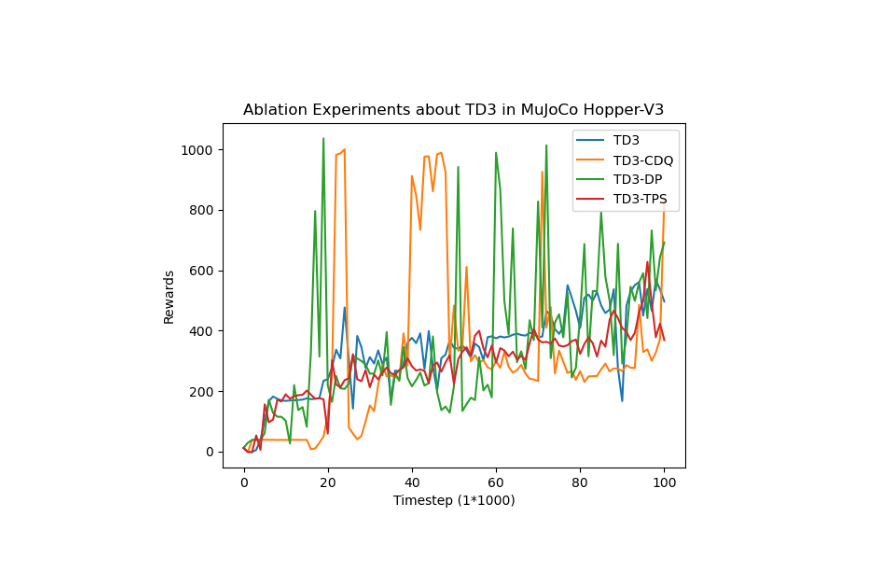

In [140]:
%matplotlib notebook
from PIL import Image
img = Image.open(os.path.join('Ablation Experiments about TD3.png'))
plt.figure("Image")
plt.imshow(img)
plt.axis('off')
plt.show()

- Q8. What is the difference between TD3(DDPG) and PPO in the OPTIMIZATION step (including but not restricted in terms of the sampling-training proportion)? Actually the improvements of PPO over TRPO was pointed  as a benefit of more training iterations, can you further improve the sample efficiency of TD3?

    - Answer-(i): Firstly, TD3 and DDPG are all off-policy，but PPO is on-policy. In TD3 and DDPG, The method of experience replay is used to update the policy by sampling old data, that is, the policy used to generate action data and the policy used for evaluation are not the same policy. But in PPO, a new policy is used to collect samples. After the policy is updated, the previous sample data needs to be discarded. Secondly, in PPO, Actor produces the mean and variance of the policy distribution. But, in TD3 and DDPG, Actor produces directly a determininstic policy. 
    
    - Answer-(ii): The improvements of PPO over TRPO in sample efficiency can be viewed as benefit of more training iterations as the importance sampling obtains an unbiased estimation of expectation based on past samples which can be regarded as "partially off-policy" and thus improving the sample efficiency.





- Q9. (i) Please describe the difference of the exploration strategies between PPO, DDPG and TD3. (ii) Provide a comparison between the exploration strategies of those continuous control algorithms and DQN.

    - Answer-(i): (a) PPO trains policies in an on-policy way. This means it explores by sampling actions according to the latest version of its policy. Since it obtains the action by sampling the probability distribution of the action, it is inherently random in this process. But this randomness depends on the initial conditions and the training process. (b) DDPG uses an off-policy method to train a policy. In order to make the DDPG policy better explored, time-related OU noise is added to the policy during the training process. (c) TD3 uses a technique at the beginning of training to improve exploration in order to facilitate the acquisition of higher quality training data. For a fixed number of steps at the beginning (using the start_steps keyword parameter setting), the agent will take actions sampled from a uniform random distribution of effective actions. After that, it will return to normal TD3 exploration.
    
    - Answer-(ii): DQN adopts the ϵ−greedy strategy that combines exploration and exploitation. It randomly selects one action from all actions with the probability of ϵ, and selects the optimal action considered by the model with the probability of 1−ϵ. However, this ϵ−greedy strategy is different from the exploration strategy in continuous control. In continuous control, such as TD3 and DDPG, they add different noise to the action space for better exploration. PPO uses the randomness of the probability distribution for better exploration, because its actions are selected according to the probability distribution and have a certain degree of randomness.


- Q10. (Bonus, 20 points) An open question. Do you think an epsilon-greedy-like exploration strategy you used in DQN/Q-learning is useful for continuous control? Will there be any problem of applying epsilon-greedy method in DDPG/TD3/PPO? Try to implement the idea and report the results.

    - Answer: In my opinion, the epsilon-greedy-like exploration strategy can also be used in continuous control. In DDPG and TD3, We can also implement a ϵ−greedy strategy, choosing randomly generated continuous actions under the probability of ϵ, and choosing the optimal action predicted by the model under the probability of 1−ϵ. I have implement the ϵ−greedy strategy in DDPG and TD3 in the following, the results shown as follow. Though the result, we can see DDPG and TD3 added ϵ−greedy strategy are great. But in PPO, in my view, PPO have used the randomness of the probability distribution for better exploration, because its actions are selected according to the probability distribution and have a certain degree of randomness. So we don't need to use epsilon-greedy-like exploration strategy in PPO.




The following four blocks download the code in official implementation to your google drive so that the following script can run them. Note that the downloaded files may disappear due to some colab mechansim.

In [41]:
!git clone https://github.com/sfujim/TD3.git

正克隆到 'TD3'...
remote: Enumerating objects: 223, done.
remote: Total 223 (delta 0), reused 0 (delta 0), pack-reused 223
接收对象中: 100% (223/223), 197.79 KiB | 444.00 KiB/s, 完成.
处理 delta 中: 100% (62/62), 完成.


In [42]:
!cp TD3/DDPG.py .

In [43]:
!cp TD3/TD3.py .

In [44]:
!cp TD3/utils.py .

In [45]:
from os import makedirs as mkdir
mkdir('results', exist_ok=True)

In [101]:
# The following scripts run the DDPG algorithm.

alias = 'ddpg' # an alias of your experiment, used as a label


import matplotlib.pyplot as plt
import numpy as np
import torch
import gym
import argparse
import os
import torch.nn.functional as F
import utils
import TD3
import DDPG

def eval_policy(policy, eval_episodes=10):
    eval_env = gym.make(ENV_NAME)

    avg_reward = 0.
    for _ in range(eval_episodes):
        state, done = eval_env.reset(), False
        while not done:
            action = policy.select_action(np.array(state))
            state, reward, done,_ = eval_env.step(action)
            avg_reward += reward

    avg_reward /= eval_episodes
    #print("---------------------------------------")
    #print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    #print("---------------------------------------")
    return avg_reward

env = gym.make(ENV_NAME)
torch.manual_seed(0)
np.random.seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = env.action_space.high[0]

args_policy_noise = 0.2
args_noise_clip = 0.5
args_policy_freq = 2
args_max_timesteps = 100000
args_expl_noise = 0.1
args_batch_size = 25
args_eval_freq = 1000
args_start_timesteps = 0

kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": 0.99,
    "tau": 0.005
}


args_policy = 'DDPG'

if args_policy == "TD3":
    # Target policy smoothing is scaled wrt the action scale
    kwargs["policy_noise"] = args_policy_noise * max_action
    kwargs["noise_clip"] = args_noise_clip * max_action
    kwargs["policy_freq"] = args_policy_freq
    policy = TD3.TD3(**kwargs)
elif args_policy == "DDPG":
    policy = DDPG.DDPG(**kwargs)
replay_buffer = utils.ReplayBuffer(state_dim, action_dim)

# Evaluate untrained policy
evaluations = [eval_policy(policy)]

state, done = env.reset(), False
episode_reward = 0
episode_timesteps = 0
episode_num = 0
counter = 0
msk_list = []        
temp_curve = [eval_policy(policy)]
temp_val = []
for t in range(int(args_max_timesteps)):
    episode_timesteps += 1
    counter += 1
    # Select action randomly or according to policy
    if t < args_start_timesteps:
        action = np.random.uniform(-max_action,max_action,action_dim)
    else:
        # ϵ−greedy strategy 
        if np.random.uniform(0,1) < 0.1:
            action = np.random.uniform(-max_action,max_action,action_dim)
        else:
            action = (
                policy.select_action(np.array(state))
                + np.random.normal(0, max_action * args_expl_noise, size=action_dim)
            ).clip(-max_action, max_action)

    # Perform action
    next_state, reward, done,_ = env.step(action) 
    done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0

    replay_buffer.add(state, action, next_state, reward, done_bool)

    state = next_state
    episode_reward += reward

    if t >= args_start_timesteps:
        '''TD3'''
        last_val = 999.
        patient = 5
        for i in range(1):
            policy.train(replay_buffer, args_batch_size)
                

    # Train agent after collecting sufficient data
    if done: 
        print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
        msk_list = []
        state, done = env.reset(), False
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1 

    # Evaluate episode
    if (t + 1) % args_eval_freq == 0:
        evaluations.append(eval_policy(policy))
        print('recent Evaluation:',evaluations[-1])
        np.save('results/evaluations_alias{}_ENV{}'.format(alias,ENV_NAME),evaluations)

Total T: 200 Episode Num: 1 Episode T: 200 Reward: -1376.161
Total T: 400 Episode Num: 2 Episode T: 200 Reward: -1526.422
Total T: 600 Episode Num: 3 Episode T: 200 Reward: -1628.067
Total T: 800 Episode Num: 4 Episode T: 200 Reward: -1622.660
Total T: 1000 Episode Num: 5 Episode T: 200 Reward: -1517.344
recent Evaluation: -1489.3857641899976
Total T: 1200 Episode Num: 6 Episode T: 200 Reward: -1381.973
Total T: 1400 Episode Num: 7 Episode T: 200 Reward: -1576.874
Total T: 1600 Episode Num: 8 Episode T: 200 Reward: -1475.352
Total T: 1800 Episode Num: 9 Episode T: 200 Reward: -1186.235
Total T: 2000 Episode Num: 10 Episode T: 200 Reward: -1197.236
recent Evaluation: -1045.988905391679
Total T: 2200 Episode Num: 11 Episode T: 200 Reward: -680.702
Total T: 2400 Episode Num: 12 Episode T: 200 Reward: -1078.568
Total T: 2600 Episode Num: 13 Episode T: 200 Reward: -833.301
Total T: 2800 Episode Num: 14 Episode T: 200 Reward: -941.850
Total T: 3000 Episode Num: 15 Episode T: 200 Reward: -895

Total T: 23600 Episode Num: 118 Episode T: 200 Reward: -119.752
Total T: 23800 Episode Num: 119 Episode T: 200 Reward: -371.238
Total T: 24000 Episode Num: 120 Episode T: 200 Reward: -257.452
recent Evaluation: -152.46072950982017
Total T: 24200 Episode Num: 121 Episode T: 200 Reward: -131.688
Total T: 24400 Episode Num: 122 Episode T: 200 Reward: -118.500
Total T: 24600 Episode Num: 123 Episode T: 200 Reward: -116.503
Total T: 24800 Episode Num: 124 Episode T: 200 Reward: -237.122
Total T: 25000 Episode Num: 125 Episode T: 200 Reward: -385.034
recent Evaluation: -128.71042934441917
Total T: 25200 Episode Num: 126 Episode T: 200 Reward: -1.409
Total T: 25400 Episode Num: 127 Episode T: 200 Reward: -118.598
Total T: 25600 Episode Num: 128 Episode T: 200 Reward: -251.767
Total T: 25800 Episode Num: 129 Episode T: 200 Reward: -237.264
Total T: 26000 Episode Num: 130 Episode T: 200 Reward: -123.701
recent Evaluation: -101.6345362096988
Total T: 26200 Episode Num: 131 Episode T: 200 Reward:

Total T: 46600 Episode Num: 233 Episode T: 200 Reward: -130.153
Total T: 46800 Episode Num: 234 Episode T: 200 Reward: -127.795
Total T: 47000 Episode Num: 235 Episode T: 200 Reward: -128.987
recent Evaluation: -169.8398706612141
Total T: 47200 Episode Num: 236 Episode T: 200 Reward: -252.749
Total T: 47400 Episode Num: 237 Episode T: 200 Reward: -116.656
Total T: 47600 Episode Num: 238 Episode T: 200 Reward: -248.575
Total T: 47800 Episode Num: 239 Episode T: 200 Reward: -244.418
Total T: 48000 Episode Num: 240 Episode T: 200 Reward: -248.065
recent Evaluation: -135.41702500303106
Total T: 48200 Episode Num: 241 Episode T: 200 Reward: -115.353
Total T: 48400 Episode Num: 242 Episode T: 200 Reward: -129.120
Total T: 48600 Episode Num: 243 Episode T: 200 Reward: -380.446
Total T: 48800 Episode Num: 244 Episode T: 200 Reward: -239.576
Total T: 49000 Episode Num: 245 Episode T: 200 Reward: -116.849
recent Evaluation: -136.48987588398137
Total T: 49200 Episode Num: 246 Episode T: 200 Rewar

Total T: 69600 Episode Num: 348 Episode T: 200 Reward: -1.253
Total T: 69800 Episode Num: 349 Episode T: 200 Reward: -128.783
Total T: 70000 Episode Num: 350 Episode T: 200 Reward: -121.520
recent Evaluation: -168.11641236704662
Total T: 70200 Episode Num: 351 Episode T: 200 Reward: -123.155
Total T: 70400 Episode Num: 352 Episode T: 200 Reward: -348.060
Total T: 70600 Episode Num: 353 Episode T: 200 Reward: -130.128
Total T: 70800 Episode Num: 354 Episode T: 200 Reward: -133.895
Total T: 71000 Episode Num: 355 Episode T: 200 Reward: -253.818
recent Evaluation: -160.0738248029586
Total T: 71200 Episode Num: 356 Episode T: 200 Reward: -376.938
Total T: 71400 Episode Num: 357 Episode T: 200 Reward: -128.798
Total T: 71600 Episode Num: 358 Episode T: 200 Reward: -118.947
Total T: 71800 Episode Num: 359 Episode T: 200 Reward: -373.024
Total T: 72000 Episode Num: 360 Episode T: 200 Reward: -120.807
recent Evaluation: -125.8719686618482
Total T: 72200 Episode Num: 361 Episode T: 200 Reward: 

Total T: 92600 Episode Num: 463 Episode T: 200 Reward: -3.842
Total T: 92800 Episode Num: 464 Episode T: 200 Reward: -130.072
Total T: 93000 Episode Num: 465 Episode T: 200 Reward: -351.762
recent Evaluation: -169.24164389583552
Total T: 93200 Episode Num: 466 Episode T: 200 Reward: -241.447
Total T: 93400 Episode Num: 467 Episode T: 200 Reward: -241.950
Total T: 93600 Episode Num: 468 Episode T: 200 Reward: -126.648
Total T: 93800 Episode Num: 469 Episode T: 200 Reward: -2.137
Total T: 94000 Episode Num: 470 Episode T: 200 Reward: -247.037
recent Evaluation: -170.47218970410563
Total T: 94200 Episode Num: 471 Episode T: 200 Reward: -123.464
Total T: 94400 Episode Num: 472 Episode T: 200 Reward: -375.456
Total T: 94600 Episode Num: 473 Episode T: 200 Reward: -134.711
Total T: 94800 Episode Num: 474 Episode T: 200 Reward: -126.461
Total T: 95000 Episode Num: 475 Episode T: 200 Reward: -245.581
recent Evaluation: -174.71240899393015
Total T: 95200 Episode Num: 476 Episode T: 200 Reward: 

In [102]:
# The following scripts run the TD3 algorithm.

alias = 'td3'


import matplotlib.pyplot as plt
import numpy as np
import torch
import gym
import argparse
import os
import torch.nn.functional as F
import utils
import TD3
import DDPG

def eval_policy(policy, eval_episodes=10):
    eval_env = gym.make(ENV_NAME)

    avg_reward = 0.
    for _ in range(eval_episodes):
        state, done = eval_env.reset(), False
        while not done:
            action = policy.select_action(np.array(state))
            state, reward, done,_ = eval_env.step(action)
            avg_reward += reward

    avg_reward /= eval_episodes
    #print("---------------------------------------")
    #print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    #print("---------------------------------------")
    return avg_reward

env = gym.make(ENV_NAME)
torch.manual_seed(0)
np.random.seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = env.action_space.high[0]

args_policy_noise = 0.2
args_noise_clip = 0.5
args_policy_freq = 2
args_max_timesteps = 100000
args_expl_noise = 0.1
args_batch_size = 25
args_eval_freq = 1000
args_start_timesteps = 0

kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": 0.99,
    "tau": 0.005
}


args_policy = 'TD3'

if args_policy == "TD3":
    # Target policy smoothing is scaled wrt the action scale
    kwargs["policy_noise"] = args_policy_noise * max_action
    kwargs["noise_clip"] = args_noise_clip * max_action
    kwargs["policy_freq"] = args_policy_freq
    policy = TD3.TD3(**kwargs)
elif args_policy == "OurDDPG":
    policy = OurDDPG.DDPG(**kwargs)
elif args_policy == "DDPG":
    policy = DDPG.DDPG(**kwargs)
replay_buffer = utils.ReplayBuffer(state_dim, action_dim)

# Evaluate untrained policy
evaluations = [eval_policy(policy)]

state, done = env.reset(), False
episode_reward = 0
episode_timesteps = 0
episode_num = 0
counter = 0
msk_list = []        
temp_curve = [eval_policy(policy)]
temp_val = []
for t in range(int(args_max_timesteps)):
    episode_timesteps += 1
    counter += 1
    # Select action randomly or according to policy
    if t < args_start_timesteps:
        action = np.random.uniform(-max_action,max_action,action_dim)
    else:
        # ϵ−greedy strategy 
        if np.random.uniform(0,1) < 0.1:
            action = np.random.uniform(-max_action,max_action,action_dim)
        else:
            action = (
                policy.select_action(np.array(state))
                + np.random.normal(0, max_action * args_expl_noise, size=action_dim)
            ).clip(-max_action, max_action)

    # Perform action
    next_state, reward, done,_ = env.step(action)
    done_bool = float(done) if episode_timesteps < env._max_episode_steps else 0

    replay_buffer.add(state, action, next_state, reward, done_bool)

    state = next_state
    episode_reward += reward

    if t >= args_start_timesteps:
        '''TD3'''
        last_val = 999.
        patient = 5
        for i in range(1):
            policy.train(replay_buffer, args_batch_size)
                

    # Train agent after collecting sufficient data
    if done: 
        print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
        msk_list = []
        state, done = env.reset(), False
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1 

    # Evaluate episode
    if (t + 1) % args_eval_freq == 0:
        evaluations.append(eval_policy(policy))
        print('recent Evaluation:',evaluations[-1])
        np.save('results/evaluations_alias{}_ENV{}'.format(alias,ENV_NAME),evaluations)

Total T: 200 Episode Num: 1 Episode T: 200 Reward: -1223.456
Total T: 400 Episode Num: 2 Episode T: 200 Reward: -1323.051
Total T: 600 Episode Num: 3 Episode T: 200 Reward: -1732.410
Total T: 800 Episode Num: 4 Episode T: 200 Reward: -1748.495
Total T: 1000 Episode Num: 5 Episode T: 200 Reward: -1654.148
recent Evaluation: -1750.8525255207642
Total T: 1200 Episode Num: 6 Episode T: 200 Reward: -1613.912
Total T: 1400 Episode Num: 7 Episode T: 200 Reward: -1676.561
Total T: 1600 Episode Num: 8 Episode T: 200 Reward: -1600.636
Total T: 1800 Episode Num: 9 Episode T: 200 Reward: -1634.766
Total T: 2000 Episode Num: 10 Episode T: 200 Reward: -1612.565
recent Evaluation: -1531.8499479355567
Total T: 2200 Episode Num: 11 Episode T: 200 Reward: -1578.314
Total T: 2400 Episode Num: 12 Episode T: 200 Reward: -1626.842
Total T: 2600 Episode Num: 13 Episode T: 200 Reward: -1592.122
Total T: 2800 Episode Num: 14 Episode T: 200 Reward: -1436.336
Total T: 3000 Episode Num: 15 Episode T: 200 Reward: 

Total T: 23600 Episode Num: 118 Episode T: 200 Reward: -124.876
Total T: 23800 Episode Num: 119 Episode T: 200 Reward: -0.785
Total T: 24000 Episode Num: 120 Episode T: 200 Reward: -246.156
recent Evaluation: -133.5292595866772
Total T: 24200 Episode Num: 121 Episode T: 200 Reward: -125.412
Total T: 24400 Episode Num: 122 Episode T: 200 Reward: -121.255
Total T: 24600 Episode Num: 123 Episode T: 200 Reward: -121.466
Total T: 24800 Episode Num: 124 Episode T: 200 Reward: -333.539
Total T: 25000 Episode Num: 125 Episode T: 200 Reward: -123.085
recent Evaluation: -153.2588206948725
Total T: 25200 Episode Num: 126 Episode T: 200 Reward: -120.983
Total T: 25400 Episode Num: 127 Episode T: 200 Reward: -335.195
Total T: 25600 Episode Num: 128 Episode T: 200 Reward: -121.966
Total T: 25800 Episode Num: 129 Episode T: 200 Reward: -117.393
Total T: 26000 Episode Num: 130 Episode T: 200 Reward: -1.180
recent Evaluation: -165.78186714219206
Total T: 26200 Episode Num: 131 Episode T: 200 Reward: -1

Total T: 46600 Episode Num: 233 Episode T: 200 Reward: -115.918
Total T: 46800 Episode Num: 234 Episode T: 200 Reward: -228.870
Total T: 47000 Episode Num: 235 Episode T: 200 Reward: -117.164
recent Evaluation: -132.07202557693822
Total T: 47200 Episode Num: 236 Episode T: 200 Reward: -120.243
Total T: 47400 Episode Num: 237 Episode T: 200 Reward: -123.779
Total T: 47600 Episode Num: 238 Episode T: 200 Reward: -118.371
Total T: 47800 Episode Num: 239 Episode T: 200 Reward: -333.130
Total T: 48000 Episode Num: 240 Episode T: 200 Reward: -120.101
recent Evaluation: -142.67007805785676
Total T: 48200 Episode Num: 241 Episode T: 200 Reward: -236.511
Total T: 48400 Episode Num: 242 Episode T: 200 Reward: -234.074
Total T: 48600 Episode Num: 243 Episode T: 200 Reward: -118.418
Total T: 48800 Episode Num: 244 Episode T: 200 Reward: -116.666
Total T: 49000 Episode Num: 245 Episode T: 200 Reward: -230.709
recent Evaluation: -94.04490969005856
Total T: 49200 Episode Num: 246 Episode T: 200 Rewar

Total T: 69600 Episode Num: 348 Episode T: 200 Reward: -1.710
Total T: 69800 Episode Num: 349 Episode T: 200 Reward: -115.149
Total T: 70000 Episode Num: 350 Episode T: 200 Reward: -120.697
recent Evaluation: -157.29972625618234
Total T: 70200 Episode Num: 351 Episode T: 200 Reward: -123.607
Total T: 70400 Episode Num: 352 Episode T: 200 Reward: -244.334
Total T: 70600 Episode Num: 353 Episode T: 200 Reward: -1.527
Total T: 70800 Episode Num: 354 Episode T: 200 Reward: -119.353
Total T: 71000 Episode Num: 355 Episode T: 200 Reward: -119.291
recent Evaluation: -180.88055734593382
Total T: 71200 Episode Num: 356 Episode T: 200 Reward: -118.440
Total T: 71400 Episode Num: 357 Episode T: 200 Reward: -233.856
Total T: 71600 Episode Num: 358 Episode T: 200 Reward: -124.511
Total T: 71800 Episode Num: 359 Episode T: 200 Reward: -121.013
Total T: 72000 Episode Num: 360 Episode T: 200 Reward: -120.702
recent Evaluation: -166.31453851869242
Total T: 72200 Episode Num: 361 Episode T: 200 Reward: 

Total T: 92600 Episode Num: 463 Episode T: 200 Reward: -126.644
Total T: 92800 Episode Num: 464 Episode T: 200 Reward: -123.109
Total T: 93000 Episode Num: 465 Episode T: 200 Reward: -247.164
recent Evaluation: -126.2401808439915
Total T: 93200 Episode Num: 466 Episode T: 200 Reward: -352.841
Total T: 93400 Episode Num: 467 Episode T: 200 Reward: -7.999
Total T: 93600 Episode Num: 468 Episode T: 200 Reward: -6.456
Total T: 93800 Episode Num: 469 Episode T: 200 Reward: -125.484
Total T: 94000 Episode Num: 470 Episode T: 200 Reward: -353.068
recent Evaluation: -137.29794689270898
Total T: 94200 Episode Num: 471 Episode T: 200 Reward: -8.728
Total T: 94400 Episode Num: 472 Episode T: 200 Reward: -237.947
Total T: 94600 Episode Num: 473 Episode T: 200 Reward: -125.657
Total T: 94800 Episode Num: 474 Episode T: 200 Reward: -129.543
Total T: 95000 Episode Num: 475 Episode T: 200 Reward: -363.594
recent Evaluation: -159.71785095544655
Total T: 95200 Episode Num: 476 Episode T: 200 Reward: -12

# Four-Solution-Maze Environment (optional)

## TODOs for you:

- Q11. (bonus) In this section, another environment named Four-Solution-Maze is provided for you to evaluate your algorithms.

The task is quite simple, yet never easy for even PPO/TD3.

The default size of the maze is 64x64, and in each game (espisode), the agent is initialized randomly in the maze. There are 4 positions in the maze that has non-trivial reward of +10, while reaching other region will recieve only a tiny punishment of -0.1. An optimal policy should be able to find the shortest path to the most recent reward region (i.e., one of the four high-reward regions.).

The action space is continuous with range [-1,1], larger actions will be clipped.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
from numpy import *
import copy

class FourWayGridWorld:
    def __init__(self, N=17,left = 10,right = 10, up=10, down = 10, seed=0):
        self.N = N
        
        self.left = left
        self.right = right
        self.up = up
        self.down = down
        self.action_space = np.asarray([np.random.rand(1),np.random.rand(1)])
        self.observation_space = np.asarray([np.random.randint(self.N),np.random.randint(self.N)])
        self.map = np.ones((N,N))*(-0.1)
        self.map[int((N-1)/2), 0] = self.left
        self.map[0, int((N-1)/2)] = self.up
        self.map[N-1, int((N-1)/2)] = self.down
        self.map[int((N-1)/2), N-1] = self.right

        self.terminal = [(int((N-1)/2),0),
                         (0,int((N-1)/2)),
                         (N-1,int((N-1)/2)),
                         (int((N-1)/2),N-1)]
        
        # self.seed = np.random.seed(seed)
        self.loc = np.asarray([np.random.randint(N),np.random.randint(N)])
        
        self.step_num = 0
        self.done = False

    def step(self,action):
        action = np.clip(action,-1,1)
        new_loc = np.clip(self.loc + action,0,self.N-1)
        self.loc = new_loc

        reward = self.map[int(round(self.loc[0])),int(round(self.loc[1]))]
        loc = (int(round(self.loc[0])),int(round(self.loc[1])))
        if loc in self.terminal:
            self.done = True

        self.step_num+=1
        return self.loc,reward, True if self.done or self.ifdone() else False

    def ifdone(self):
        if self.step_num >= 2*self.N:
            return True
        else:
            return False

    def render(self):
        map_self = copy.deepcopy(self.map)
        map_self[int(self.loc[0]),int(self.loc[1])] = -5
        plt.imshow(map_self)

    def reset(self, seed=0):
        self.done = False

        # self.seed = np.random.seed(seed)

        self.map = np.ones((self.N,self.N))*(-0.1)
        self.map[int((self.N-1)/2),0] = self.left
        self.map[0,int((self.N-1)/2)] = self.up
        self.map[self.N-1,int((self.N-1)/2)] = self.down
        self.map[int((self.N-1)/2),self.N-1] = self.right
        self.loc = np.asarray([np.random.randint(self.N),np.random.randint(self.N)])
        self.step_num = 0
        return self.loc

In [142]:
env = FourWayGridWorld(33)

In [143]:
env.reset()

array([23, 11])

<IPython.core.display.Javascript object>


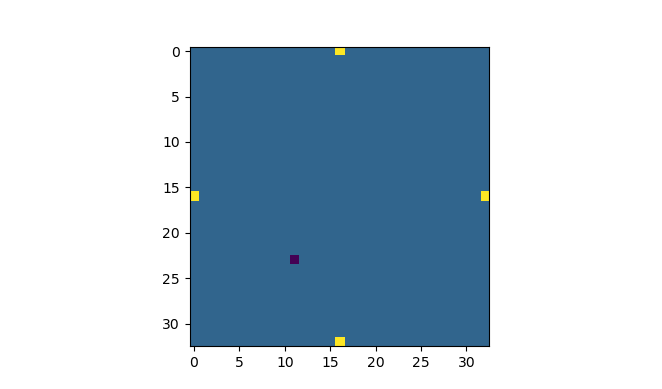

In [144]:
env.render()

# PPO-FourWayGridWorld

In [149]:
# You need not to rivese this unless you want to try other hyper-parameter settings
# in which case you may revise the default values of class args()
from IPython import display
import torch
import torch.nn as nn
import torch.optim as opt
from torch import Tensor
from torch.autograd import Variable
from collections import namedtuple
from itertools import count
import torch.nn.functional as F
import matplotlib.pyplot as plt
from os.path import join as joindir
from os import makedirs as mkdir
import pandas as pd
import numpy as np
import argparse
import datetime
import math
import random

ENV_NAME = 'FourWayGridWorld'

Transition = namedtuple('Transition', ('state', 'value', 'action', 'logproba', 'mask', 'next_state', 'reward'))
env = FourWayGridWorld(33)
env.reset()

EPS = 1e-10 # you may need this tiny value somewhere, and think about why?
RESULT_DIR = 'Result_PPO'
mkdir(RESULT_DIR, exist_ok=True)
mkdir(ENV_NAME.split('-')[0]+'/CheckPoints', exist_ok=True)
mkdir(ENV_NAME.split('-')[0]+'/Rwds', exist_ok=True)
rwds = []
rwds_history = []

class args(object):
    hid_num = 256
    drop_prob = 0.1
#     env_name = ENV_NAME
    seed = 1
    num_episode = 300
    batch_size = 5120
    max_step_per_round = 2000
    gamma = 0.99
    lamda = 0.95
    log_num_episode = 1
    num_epoch = 10
    minibatch_size = 512
    clip = 0.2
    loss_coeff_value = 0.5
    loss_coeff_entropy = 0.01
    lr = 3e-4
    num_parallel_run = 1
    # tricks
    schedule_adam = 'linear'
    schedule_clip = 'linear'
    layer_norm = True
    state_norm = True
    advantage_norm = True
    lossvalue_norm = True

In [150]:
# Here, you need to finish the first 5 tasks.
class ActorCritic(nn.Module):
    def __init__(self, num_inputs, num_outputs, layer_norm=True):
        super(ActorCritic, self).__init__()
        '''
        Q1:
        Initialize your networks
        '''
        self.actor_fc1 = nn.Linear(2, args.hid_num)
        self.actor_fc2 = nn.Linear(args.hid_num, args.hid_num)
        self.actor_fc3 = nn.Linear(args.hid_num, 2)
        self.actor_logstd = nn.Parameter(torch.zeros(1, num_outputs))
        #self.actor_logstd = nn.Linear(args.hid_num, 1)


        self.critic_fc1 = nn.Linear(2, args.hid_num)
        self.critic_fc2 = nn.Linear(args.hid_num, args.hid_num)
        self.critic_fc3 = nn.Linear(args.hid_num, 1)

        if layer_norm:
            self.layer_norm(self.actor_fc1, std=1.0)
            self.layer_norm(self.actor_fc2, std=1.0)
            self.layer_norm(self.actor_fc3, std=0.01)

            self.layer_norm(self.critic_fc1, std=1.0)
            self.layer_norm(self.critic_fc2, std=1.0)
            self.layer_norm(self.critic_fc3, std=1.0)

    @staticmethod
    def layer_norm(layer, std=1.0, bias_const=0.0):
        torch.nn.init.orthogonal_(layer.weight, std)
        torch.nn.init.constant_(layer.bias, bias_const)

    def forward(self, states):
        """
        Q2.1:
        run policy network (actor) as well as value network (critic)
        :param states: a tensor represents states
        :return: 3 Tensor2
        your _forward_actor() function should return both the mean value of action and the log-standard deviation of the action
        """

        action_mean, action_logstd = self._forward_actor(states)
        critic_value = self._forward_critic(states)
        return action_mean, action_logstd, critic_value

    def _forward_actor(self, states):
        '''
        Q2.2:
        build something like 
        x = activation (actor_fc(state))
        the logstd output has already been provided
        '''
        x1 = F.relu(self.actor_fc1(states))
        x2 = F.relu(self.actor_fc2(x1))
        action_mean = F.tanh(self.actor_fc3(x2))
        action_logstd = self.actor_logstd.expand_as(action_mean)
        #action_logstd = F.softplus(self.actor_logstd(x2))
        return action_mean, action_logstd

    def _forward_critic(self, states):
        '''
        Q2.3:
        build something like 
        x = activation (critic_fc(state))'''
        c1 = F.relu(self.critic_fc1(states))
        c2 = F.relu(self.critic_fc2(c1))
        critic_value = self.critic_fc3(c2)
        return critic_value

    def select_action(self, action_mean, action_logstd, return_logproba=True):
        """
        Q3.1:
        given mean and std, sample an action from normal(mean, std)
        also returns probability of the given chosen
        """
        action_std = torch.exp(action_logstd)
        action = torch.normal(action_mean, action_std)
        if return_logproba:
            logproba = self._normal_logproba(action, action_mean, action_logstd, action_std)
        
        return action, logproba

    @staticmethod
    def _normal_logproba(x, mean, logstd, std=None):
        '''
        Q3.2:
        given a mean and logstd of a gaussian,
        calculate the log-probability of a given x'''
        
        if std is None:
            std = torch.exp(logstd)

        std_sq = std.pow(2)
        logproba = - 0.5 * math.log(2 * math.pi) - logstd - (x - mean).pow(2) / (2 * std_sq)

        return logproba.sum(1)


    def get_logproba(self, states, actions):
        """
        return probability of chosen the given actions under corresponding states of current network
        :param states: Tensor
        :param actions: Tensor
        """
        action_mean, action_logstd = self._forward_actor(states)
        action_mean = action_mean.cpu()
        action_logstd = action_logstd.cpu()
        logproba = self._normal_logproba(actions, action_mean, action_logstd)
        return logproba


class Memory(object):
    def __init__(self):
        self.memory = []

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self):
        return Transition(*zip(*self.memory))

    def __len__(self):
        return len(self.memory)

# env = gym.make(ENV_NAME)  
num_inputs = env.observation_space.shape[0]
num_actions = env.action_space.shape[0]
network = ActorCritic(num_inputs, num_actions, layer_norm=args.layer_norm)
network.train()
def ppo(args):
#     env = gym.make(args.env_name)
    num_inputs = env.observation_space.shape[0]
    num_actions = env.action_space.shape[0]

#     env.seed(args.seed)
    torch.manual_seed(args.seed)

    #network = ActorCritic(num_inputs, num_actions, layer_norm=args.layer_norm)
    optimizer = opt.Adam(network.parameters(), lr=args.lr)

    running_state = ZFilter((num_inputs,), clip=5.0)

    # record average 1-round cumulative reward in every episode
    reward_record = []
    global_steps = 0

    lr_now = args.lr
    clip_now = args.clip

    for i_episode in range(args.num_episode):
        # step1: perform current policy to collect trajectories
        # this is an on-policy method!
        memory = Memory()
        num_steps = 0
        reward_list = []
        len_list = []
        while num_steps < args.batch_size:
            state = env.reset()
            if args.state_norm:
                state = running_state(state)
            reward_sum = 0
            for t in range(args.max_step_per_round):
                action_mean, action_logstd, value = network(Tensor(state).unsqueeze(0))
                action, logproba = network.select_action(action_mean, action_logstd)
                action = action.cpu().data.numpy()[0]
                logproba = logproba.cpu().data.numpy()[0]
                next_state, reward, done = env.step(action)

                reward_sum += reward
                if args.state_norm:
                    next_state = running_state(next_state)
                mask = 0 if done else 1

                memory.push(state, value, action, logproba, mask, next_state, reward)

                if done:
                    break

                state = next_state

            num_steps += (t + 1)
            global_steps += (t + 1)
            reward_list.append(reward_sum)
            len_list.append(t + 1)
        reward_record.append({
            'episode': i_episode, 
            'steps': global_steps, 
            'meanepreward': np.mean(reward_list), 
            'meaneplen': np.mean(len_list)})
        rwds.extend(reward_list)
        batch = memory.sample()
        batch_size = len(memory)

        # step2: extract variables from trajectories
        rewards = Tensor(batch.reward)
        values = Tensor(batch.value)
        masks = Tensor(batch.mask)
        actions = Tensor(batch.action)
        states = Tensor(batch.state)
        oldlogproba = Tensor(batch.logproba)

        returns = Tensor(batch_size)
        deltas = Tensor(batch_size)
        advantages = Tensor(batch_size)

        prev_return = 0
        prev_value = 0
        prev_advantage = 0
        for i in reversed(range(batch_size)):
            returns[i] = rewards[i] + args.gamma * prev_return * masks[i]
            deltas[i] = rewards[i] + args.gamma * prev_value * masks[i] - values[i]
            # ref: https://arxiv.org/pdf/1506.02438.pdf (generalization advantage estimate)
            advantages[i] = deltas[i] + args.gamma * args.lamda * prev_advantage * masks[i]

            prev_return = returns[i]
            prev_value = values[i]
            prev_advantage = advantages[i]
        if args.advantage_norm:
            advantages = (advantages - advantages.mean()) / (advantages.std() + EPS)

        for i_epoch in range(int(args.num_epoch * batch_size / args.minibatch_size)):
            # sample from current batch
            minibatch_ind = np.random.choice(batch_size, args.minibatch_size, replace=False)
            minibatch_states = states[minibatch_ind]
            minibatch_actions = actions[minibatch_ind]
            minibatch_oldlogproba = oldlogproba[minibatch_ind]
            minibatch_newlogproba = network.get_logproba(minibatch_states, minibatch_actions)
            minibatch_advantages = advantages[minibatch_ind]
            minibatch_returns = returns[minibatch_ind]
            minibatch_newvalues = network._forward_critic(minibatch_states).flatten()
            '''
            Q4: 

            HERE: 
            now you have the advantages, and log-probabilities (both pi_new and pi_old)
            you need to do optimization according to the CLIP loss
            
            '''
            ratio = torch.exp(minibatch_newlogproba - minibatch_oldlogproba)

            surr1 = ratio * minibatch_advantages
            surr2 = torch.clamp(ratio, 1.0 - clip_now, 1.0 + clip_now) * minibatch_advantages
            loss_surr = -torch.min(surr1, surr2).mean()

            if args.lossvalue_norm:
                minibatch_return_6std = 6 * minibatch_returns.std()
                loss_value = torch.mean((minibatch_newvalues - minibatch_returns).pow(2)) / minibatch_return_6std
            else:
                loss_value = torch.mean((minibatch_newvalues - minibatch_returns).pow(2))

            loss_entropy = torch.mean(torch.exp(minibatch_newlogproba) * minibatch_newlogproba)

            total_loss = loss_surr + args.loss_coeff_value * loss_value + args.loss_coeff_entropy * loss_entropy
            optimizer.zero_grad()
            total_loss.backward()
            optimizer.step()

        if args.schedule_clip == 'linear':
            ep_ratio = 1 - (i_episode / args.num_episode)
            clip_now = args.clip * ep_ratio

        if args.schedule_adam == 'linear':
            ep_ratio = 1 - (i_episode / args.num_episode)
            lr_now = args.lr * ep_ratio
            for g in optimizer.param_groups:
                g['lr'] = lr_now

        if i_episode % args.log_num_episode == 0:
            print('Finished episode: {} Reward: {:.4f} total_loss = {:.4f} = {:.4f} + {} * {:.4f} + {} * {:.4f}' \
                .format(i_episode, reward_record[-1]['meanepreward'], total_loss.data, loss_surr.data, args.loss_coeff_value, 
                loss_value.data, args.loss_coeff_entropy, loss_entropy.data))
            print('-----------------')

    return reward_record

def test(args):
    record_dfs = []
    for i in range(args.num_parallel_run):
        args.seed += 1
        reward_record = pd.DataFrame(ppo(args))
        reward_record['#parallel_run'] = i
        record_dfs.append(reward_record)
    record_dfs = pd.concat(record_dfs, axis=0)
    record_dfs.to_csv(joindir(RESULT_DIR, 'ppo-record-{}.csv'.format(args.env_name)))

if __name__ == '__main__':
    for envname in [ENV_NAME]:
        test(args)

torch.save(network.state_dict(),args.env_name.split('-')[0]+'/CheckPoints/checkpoint_Four-Solution-Maze_new_{0}hidden'.format(args.hid_num)) 
np.savetxt(args.env_name.split('-')[0]+'/Rwds/Four-Solution-Maze_rwds_new_{0}hidden'.format(args.hid_num),rwds)

Finished episode: 0 Reward: -5.4171 total_loss = 0.2106 = 0.0189 + 0.5 * 0.3871 + 0.01 * -0.1842
-----------------
Finished episode: 1 Reward: -5.3284 total_loss = 0.2340 = 0.0266 + 0.5 * 0.4188 + 0.01 * -0.1908
-----------------
Finished episode: 2 Reward: -4.0729 total_loss = 0.2284 = -0.0338 + 0.5 * 0.5281 + 0.01 * -0.1898
-----------------
Finished episode: 3 Reward: -4.8915 total_loss = 0.2544 = 0.0158 + 0.5 * 0.4812 + 0.01 * -0.1983
-----------------
Finished episode: 4 Reward: -3.3333 total_loss = 0.2408 = -0.0353 + 0.5 * 0.5561 + 0.01 * -0.1940
-----------------
Finished episode: 5 Reward: -2.4615 total_loss = 0.1504 = -0.0539 + 0.5 * 0.4125 + 0.01 * -0.1961
-----------------
Finished episode: 6 Reward: -0.7820 total_loss = 0.3061 = 0.0285 + 0.5 * 0.5592 + 0.01 * -0.1959
-----------------
Finished episode: 7 Reward: 0.8848 total_loss = 0.2474 = -0.0083 + 0.5 * 0.5154 + 0.01 * -0.2038
-----------------
Finished episode: 8 Reward: 2.1637 total_loss = 0.2840 = -0.0126 + 0.5 * 0.59

Finished episode: 71 Reward: 9.0634 total_loss = 0.0448 = 0.0378 + 0.5 * 0.0045 + 0.01 * 0.4819
-----------------
Finished episode: 72 Reward: 9.0528 total_loss = 0.0384 = 0.0300 + 0.5 * 0.0056 + 0.01 * 0.5556
-----------------
Finished episode: 73 Reward: 9.0768 total_loss = 0.0175 = 0.0075 + 0.5 * 0.0080 + 0.01 * 0.6050
-----------------
Finished episode: 74 Reward: 9.0888 total_loss = -0.0434 = -0.0519 + 0.5 * 0.0042 + 0.01 * 0.6360
-----------------
Finished episode: 75 Reward: 9.0106 total_loss = 0.0976 = 0.0886 + 0.5 * 0.0046 + 0.01 * 0.6659
-----------------
Finished episode: 76 Reward: 9.0638 total_loss = 0.0251 = 0.0153 + 0.5 * 0.0051 + 0.01 * 0.7203
-----------------
Finished episode: 77 Reward: 9.0365 total_loss = -0.0371 = -0.0470 + 0.5 * 0.0043 + 0.01 * 0.7767
-----------------
Finished episode: 78 Reward: 9.0848 total_loss = 0.0221 = 0.0120 + 0.5 * 0.0039 + 0.01 * 0.8227
-----------------
Finished episode: 79 Reward: 9.0756 total_loss = -0.0181 = -0.0276 + 0.5 * 0.0025 + 

Finished episode: 143 Reward: 9.1192 total_loss = 0.0459 = -0.0103 + 0.5 * 0.0012 + 0.01 * 5.5626
-----------------
Finished episode: 144 Reward: 9.1133 total_loss = 0.0484 = -0.0059 + 0.5 * 0.0035 + 0.01 * 5.2657
-----------------
Finished episode: 145 Reward: 9.1116 total_loss = 0.0649 = 0.0106 + 0.5 * 0.0015 + 0.01 * 5.3579
-----------------
Finished episode: 146 Reward: 9.1356 total_loss = 0.0728 = 0.0131 + 0.5 * 0.0022 + 0.01 * 5.8575
-----------------
Finished episode: 147 Reward: 9.1514 total_loss = 0.0806 = 0.0236 + 0.5 * 0.0012 + 0.01 * 5.6384
-----------------
Finished episode: 148 Reward: 9.1056 total_loss = -0.0143 = -0.0677 + 0.5 * 0.0013 + 0.01 * 5.2822
-----------------
Finished episode: 149 Reward: 9.1408 total_loss = 0.0165 = -0.0397 + 0.5 * 0.0028 + 0.01 * 5.4813
-----------------
Finished episode: 150 Reward: 9.1383 total_loss = 0.0811 = 0.0268 + 0.5 * 0.0016 + 0.01 * 5.3578
-----------------
Finished episode: 151 Reward: 9.1550 total_loss = 0.0588 = -0.0002 + 0.5 * 

Finished episode: 214 Reward: 9.0795 total_loss = 0.0199 = -0.0438 + 0.5 * 0.0017 + 0.01 * 6.2821
-----------------
Finished episode: 215 Reward: 9.1079 total_loss = 0.0544 = -0.0061 + 0.5 * 0.0031 + 0.01 * 5.8932
-----------------
Finished episode: 216 Reward: 9.1591 total_loss = -0.0409 = -0.1061 + 0.5 * 0.0076 + 0.01 * 6.1436
-----------------
Finished episode: 217 Reward: 9.0951 total_loss = 0.0335 = -0.0298 + 0.5 * 0.0014 + 0.01 * 6.2540
-----------------
Finished episode: 218 Reward: 9.1203 total_loss = 0.0458 = -0.0142 + 0.5 * 0.0016 + 0.01 * 5.9262
-----------------
Finished episode: 219 Reward: 9.1586 total_loss = 0.0774 = 0.0188 + 0.5 * 0.0039 + 0.01 * 5.6619
-----------------
Finished episode: 220 Reward: 9.0884 total_loss = 0.0000 = -0.0573 + 0.5 * 0.0013 + 0.01 * 5.6638
-----------------
Finished episode: 221 Reward: 9.1129 total_loss = 0.0635 = 0.0037 + 0.5 * 0.0012 + 0.01 * 5.9248
-----------------
Finished episode: 222 Reward: 9.1445 total_loss = 0.0468 = -0.0140 + 0.5 

Finished episode: 285 Reward: 9.1372 total_loss = 0.1099 = 0.0435 + 0.5 * 0.0013 + 0.01 * 6.5696
-----------------
Finished episode: 286 Reward: 9.1247 total_loss = 0.0876 = 0.0226 + 0.5 * 0.0015 + 0.01 * 6.4230
-----------------
Finished episode: 287 Reward: 9.1210 total_loss = 0.0091 = -0.0581 + 0.5 * 0.0013 + 0.01 * 6.6556
-----------------
Finished episode: 288 Reward: 9.0916 total_loss = 0.1472 = 0.0791 + 0.5 * 0.0031 + 0.01 * 6.6511
-----------------
Finished episode: 289 Reward: 9.1193 total_loss = 0.0559 = -0.0126 + 0.5 * 0.0026 + 0.01 * 6.7228
-----------------
Finished episode: 290 Reward: 9.1148 total_loss = 0.0296 = -0.0341 + 0.5 * 0.0046 + 0.01 * 6.1394
-----------------
Finished episode: 291 Reward: 9.1070 total_loss = 0.0848 = 0.0171 + 0.5 * 0.0014 + 0.01 * 6.7001
-----------------
Finished episode: 292 Reward: 9.1499 total_loss = 0.0670 = 0.0003 + 0.5 * 0.0013 + 0.01 * 6.6068
-----------------
Finished episode: 293 Reward: 9.1410 total_loss = 0.0189 = -0.0463 + 0.5 * 0.

<IPython.core.display.Javascript object>


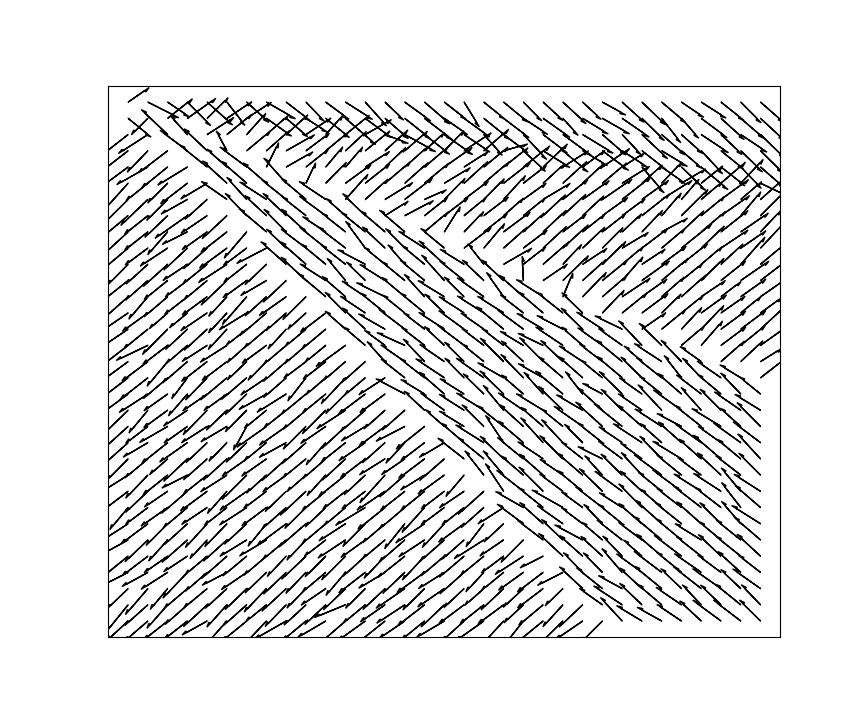

([], [])

In [151]:
# This section is used to visualize your learned policy
from torch import Tensor
output_i = np.zeros((33,33))
output_j = np.zeros((33,33))
output_i_m = np.zeros((33,33))
output_j_m = np.zeros((33,33))
value_ij = np.zeros((33,33))
for i in range(33):
    for j in range(33):
        states = Tensor(np.asarray([i,j])).float().unsqueeze(0)
        
        '''
        you need to revise the following line, 
        to fit your policy/network outputs
        '''
        action_mean, action_logstd, value = network(states)
        action, logproba = network.select_action(action_mean, action_logstd)
        action = action.cpu().data.numpy()[0]
        logproba = logproba.cpu().data.numpy()[0]
#         action, value = policy(states)
        output_i[i,j] = action[0]
        output_j[i,j] = action[1]
        value_ij[i,j] = value
        
plt.figure(figsize= (5,5))
for i in range(33):
    for j in range(33):
        plt.arrow(j,-i,output_j[i,j],-output_i[i,j],head_width=0.2,shape='left')
xlim(-1,33)
ylim(-33,1)
yticks([2*i-32 for i in range(17)],[2*i for i in range(17)])
plt.xticks([])
plt.yticks([])

# TD3-FourWayGridWorld

In [164]:
# The following scripts run the TD3 algorithm.

alias = 'td3'
ENV_NAME = 'FourWayGridWorld'


import matplotlib.pyplot as plt
import numpy as np
import torch
import gym
import argparse
import os
import torch.nn.functional as F
import utils
import TD3
import DDPG

def eval_policy(policy, eval_episodes=10):
    eval_env = FourWayGridWorld(33)

    avg_reward = 0.
    for _ in range(eval_episodes):
        state, done = eval_env.reset(), False
        while not done:
            action = policy.select_action(np.array(state))
            state, reward, done = eval_env.step(action)
            avg_reward += reward

    avg_reward /= eval_episodes
    #print("---------------------------------------")
    #print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    #print("---------------------------------------")
    return avg_reward

env = FourWayGridWorld(33)
torch.manual_seed(0)
np.random.seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = 1

args_policy_noise = 0.001
args_noise_clip = 0.5
args_policy_freq = 2
args_max_timesteps = 100000
args_expl_noise = 0.1
args_batch_size = 25
args_eval_freq = 1000
args_start_timesteps = 0

kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": 0.99,
    "tau": 0.005
}


args_policy = 'TD3'

if args_policy == "TD3":
    # Target policy smoothing is scaled wrt the action scale
    kwargs["policy_noise"] = args_policy_noise * max_action
    kwargs["noise_clip"] = args_noise_clip * max_action
    kwargs["policy_freq"] = args_policy_freq
    policy = TD3.TD3(**kwargs)
elif args_policy == "OurDDPG":
    policy = OurDDPG.DDPG(**kwargs)
elif args_policy == "DDPG":
    policy = DDPG.DDPG(**kwargs)
replay_buffer = utils.ReplayBuffer(state_dim, action_dim)

# Evaluate untrained policy
evaluations = [eval_policy(policy)]

state, done = env.reset(), False
episode_reward = 0
episode_timesteps = 0
episode_num = 0
counter = 0
msk_list = []        
temp_curve = [eval_policy(policy)]
temp_val = []
for t in range(int(args_max_timesteps)):
    episode_timesteps += 1
    counter += 1
    # Select action randomly or according to policy
    if t < args_start_timesteps:
        action = np.random.uniform(-max_action,max_action,action_dim)
    else:
        # ϵ−greedy strategy 
        if np.random.uniform(0,1) < 0.1:
            action = np.random.uniform(-max_action,max_action,action_dim)
        else:
            action = (
                policy.select_action(np.array(state))
                + np.random.normal(0, max_action * args_expl_noise, size=action_dim)
            ).clip(-max_action, max_action)

    # Perform action
    next_state, reward, done = env.step(action)
    done_bool = float(done) if episode_timesteps < 2*env.N else 0

    replay_buffer.add(state, action, next_state, reward, done_bool)

    state = next_state
    episode_reward += reward

    if t >= args_start_timesteps:
        '''TD3'''
        last_val = 999.
        patient = 5
        for i in range(1):
            policy.train(replay_buffer, args_batch_size)
                

    # Train agent after collecting sufficient data
    if done: 
        print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
        msk_list = []
        state, done = env.reset(), False
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1 

    # Evaluate episode
    if (t + 1) % args_eval_freq == 0:
        evaluations.append(eval_policy(policy))
        print('recent Evaluation:',evaluations[-1])
        np.save('results/FourWayGridWorld_evaluations_alias{}_ENV{}'.format(alias,ENV_NAME),evaluations)

Total T: 66 Episode Num: 1 Episode T: 66 Reward: -6.600
Total T: 132 Episode Num: 2 Episode T: 66 Reward: -6.600
Total T: 198 Episode Num: 3 Episode T: 66 Reward: -6.600
Total T: 236 Episode Num: 4 Episode T: 38 Reward: 6.300
Total T: 251 Episode Num: 5 Episode T: 15 Reward: 8.600
Total T: 303 Episode Num: 6 Episode T: 52 Reward: 4.900
Total T: 369 Episode Num: 7 Episode T: 66 Reward: -6.600
Total T: 435 Episode Num: 8 Episode T: 66 Reward: -6.600
Total T: 449 Episode Num: 9 Episode T: 14 Reward: 8.700
Total T: 468 Episode Num: 10 Episode T: 19 Reward: 8.200
Total T: 534 Episode Num: 11 Episode T: 66 Reward: -6.600
Total T: 600 Episode Num: 12 Episode T: 66 Reward: -6.600
Total T: 608 Episode Num: 13 Episode T: 8 Reward: 9.300
Total T: 674 Episode Num: 14 Episode T: 66 Reward: -6.600
Total T: 740 Episode Num: 15 Episode T: 66 Reward: -6.600
Total T: 806 Episode Num: 16 Episode T: 66 Reward: -6.600
Total T: 872 Episode Num: 17 Episode T: 66 Reward: -6.600
Total T: 938 Episode Num: 18 Ep

Total T: 5195 Episode Num: 140 Episode T: 48 Reward: 5.300
Total T: 5246 Episode Num: 141 Episode T: 51 Reward: 5.000
Total T: 5267 Episode Num: 142 Episode T: 21 Reward: 8.000
Total T: 5286 Episode Num: 143 Episode T: 19 Reward: 8.200
Total T: 5352 Episode Num: 144 Episode T: 66 Reward: -6.600
Total T: 5408 Episode Num: 145 Episode T: 56 Reward: 4.500
Total T: 5474 Episode Num: 146 Episode T: 66 Reward: -6.600
Total T: 5489 Episode Num: 147 Episode T: 15 Reward: 8.600
Total T: 5555 Episode Num: 148 Episode T: 66 Reward: -6.600
Total T: 5560 Episode Num: 149 Episode T: 5 Reward: 9.600
Total T: 5565 Episode Num: 150 Episode T: 5 Reward: 9.600
Total T: 5577 Episode Num: 151 Episode T: 12 Reward: 8.900
Total T: 5615 Episode Num: 152 Episode T: 38 Reward: 6.300
Total T: 5650 Episode Num: 153 Episode T: 35 Reward: 6.600
Total T: 5675 Episode Num: 154 Episode T: 25 Reward: 7.600
Total T: 5687 Episode Num: 155 Episode T: 12 Reward: 8.900
Total T: 5738 Episode Num: 156 Episode T: 51 Reward: 5.

Total T: 10905 Episode Num: 275 Episode T: 66 Reward: -6.600
Total T: 10914 Episode Num: 276 Episode T: 9 Reward: 9.200
Total T: 10980 Episode Num: 277 Episode T: 66 Reward: -6.600
recent Evaluation: -3.4400000000000204
Total T: 11046 Episode Num: 278 Episode T: 66 Reward: -6.600
Total T: 11112 Episode Num: 279 Episode T: 66 Reward: -6.600
Total T: 11178 Episode Num: 280 Episode T: 66 Reward: -6.600
Total T: 11244 Episode Num: 281 Episode T: 66 Reward: -6.600
Total T: 11310 Episode Num: 282 Episode T: 66 Reward: -6.600
Total T: 11376 Episode Num: 283 Episode T: 66 Reward: -6.600
Total T: 11442 Episode Num: 284 Episode T: 66 Reward: -6.600
Total T: 11508 Episode Num: 285 Episode T: 66 Reward: -6.600
Total T: 11574 Episode Num: 286 Episode T: 66 Reward: -6.600
Total T: 11640 Episode Num: 287 Episode T: 66 Reward: -6.600
Total T: 11655 Episode Num: 288 Episode T: 15 Reward: 8.600
Total T: 11721 Episode Num: 289 Episode T: 66 Reward: -6.600
Total T: 11741 Episode Num: 290 Episode T: 20 Rew

Total T: 17182 Episode Num: 406 Episode T: 66 Reward: -6.600
Total T: 17205 Episode Num: 407 Episode T: 23 Reward: 7.800
Total T: 17271 Episode Num: 408 Episode T: 66 Reward: -6.600
Total T: 17283 Episode Num: 409 Episode T: 12 Reward: 8.900
Total T: 17317 Episode Num: 410 Episode T: 34 Reward: 6.700
Total T: 17344 Episode Num: 411 Episode T: 27 Reward: 7.400
Total T: 17410 Episode Num: 412 Episode T: 66 Reward: -6.600
Total T: 17422 Episode Num: 413 Episode T: 12 Reward: 8.900
Total T: 17488 Episode Num: 414 Episode T: 66 Reward: -6.600
Total T: 17496 Episode Num: 415 Episode T: 8 Reward: 9.300
Total T: 17512 Episode Num: 416 Episode T: 16 Reward: 8.500
Total T: 17521 Episode Num: 417 Episode T: 9 Reward: 9.200
Total T: 17535 Episode Num: 418 Episode T: 14 Reward: 8.700
Total T: 17601 Episode Num: 419 Episode T: 66 Reward: -6.600
Total T: 17667 Episode Num: 420 Episode T: 66 Reward: -6.600
Total T: 17685 Episode Num: 421 Episode T: 18 Reward: 8.300
Total T: 17700 Episode Num: 422 Epis

Total T: 22632 Episode Num: 540 Episode T: 53 Reward: 4.800
Total T: 22698 Episode Num: 541 Episode T: 66 Reward: -6.600
Total T: 22764 Episode Num: 542 Episode T: 66 Reward: -6.600
Total T: 22830 Episode Num: 543 Episode T: 66 Reward: -6.600
Total T: 22896 Episode Num: 544 Episode T: 66 Reward: -6.600
Total T: 22962 Episode Num: 545 Episode T: 66 Reward: -6.600
recent Evaluation: -3.550000000000052
Total T: 23028 Episode Num: 546 Episode T: 66 Reward: -6.600
Total T: 23041 Episode Num: 547 Episode T: 13 Reward: 8.800
Total T: 23051 Episode Num: 548 Episode T: 10 Reward: 9.100
Total T: 23117 Episode Num: 549 Episode T: 66 Reward: -6.600
Total T: 23183 Episode Num: 550 Episode T: 66 Reward: -6.600
Total T: 23224 Episode Num: 551 Episode T: 41 Reward: 6.000
Total T: 23290 Episode Num: 552 Episode T: 66 Reward: -6.600
Total T: 23309 Episode Num: 553 Episode T: 19 Reward: 8.200
Total T: 23375 Episode Num: 554 Episode T: 66 Reward: -6.600
Total T: 23419 Episode Num: 555 Episode T: 44 Reward

Total T: 28087 Episode Num: 673 Episode T: 66 Reward: -6.600
Total T: 28098 Episode Num: 674 Episode T: 11 Reward: 9.000
Total T: 28164 Episode Num: 675 Episode T: 66 Reward: -6.600
Total T: 28190 Episode Num: 676 Episode T: 26 Reward: 7.500
Total T: 28202 Episode Num: 677 Episode T: 12 Reward: 8.900
Total T: 28213 Episode Num: 678 Episode T: 11 Reward: 9.000
Total T: 28279 Episode Num: 679 Episode T: 66 Reward: -6.600
Total T: 28292 Episode Num: 680 Episode T: 13 Reward: 8.800
Total T: 28358 Episode Num: 681 Episode T: 66 Reward: -6.600
Total T: 28424 Episode Num: 682 Episode T: 66 Reward: -6.600
Total T: 28428 Episode Num: 683 Episode T: 4 Reward: 9.700
Total T: 28494 Episode Num: 684 Episode T: 66 Reward: -6.600
Total T: 28560 Episode Num: 685 Episode T: 66 Reward: -6.600
Total T: 28626 Episode Num: 686 Episode T: 66 Reward: -6.600
Total T: 28692 Episode Num: 687 Episode T: 66 Reward: -6.600
Total T: 28758 Episode Num: 688 Episode T: 66 Reward: -6.600
Total T: 28804 Episode Num: 689

Total T: 33921 Episode Num: 806 Episode T: 66 Reward: -6.600
Total T: 33931 Episode Num: 807 Episode T: 10 Reward: 9.100
Total T: 33997 Episode Num: 808 Episode T: 66 Reward: -6.600
recent Evaluation: -1.9799999999999998
Total T: 34008 Episode Num: 809 Episode T: 11 Reward: 9.000
Total T: 34074 Episode Num: 810 Episode T: 66 Reward: -6.600
Total T: 34140 Episode Num: 811 Episode T: 66 Reward: -6.600
Total T: 34206 Episode Num: 812 Episode T: 66 Reward: -6.600
Total T: 34210 Episode Num: 813 Episode T: 4 Reward: 9.700
Total T: 34226 Episode Num: 814 Episode T: 16 Reward: 8.500
Total T: 34292 Episode Num: 815 Episode T: 66 Reward: -6.600
Total T: 34358 Episode Num: 816 Episode T: 66 Reward: -6.600
Total T: 34375 Episode Num: 817 Episode T: 17 Reward: 8.400
Total T: 34441 Episode Num: 818 Episode T: 66 Reward: -6.600
Total T: 34507 Episode Num: 819 Episode T: 66 Reward: -6.600
Total T: 34573 Episode Num: 820 Episode T: 66 Reward: -6.600
Total T: 34639 Episode Num: 821 Episode T: 66 Reward

Total T: 39430 Episode Num: 938 Episode T: 66 Reward: -6.600
Total T: 39436 Episode Num: 939 Episode T: 6 Reward: 9.500
Total T: 39439 Episode Num: 940 Episode T: 3 Reward: 9.800
Total T: 39458 Episode Num: 941 Episode T: 19 Reward: 8.200
Total T: 39524 Episode Num: 942 Episode T: 66 Reward: -6.600
Total T: 39544 Episode Num: 943 Episode T: 20 Reward: 8.100
Total T: 39552 Episode Num: 944 Episode T: 8 Reward: 9.300
Total T: 39618 Episode Num: 945 Episode T: 66 Reward: -6.600
Total T: 39635 Episode Num: 946 Episode T: 17 Reward: 8.400
Total T: 39645 Episode Num: 947 Episode T: 10 Reward: 9.100
Total T: 39711 Episode Num: 948 Episode T: 66 Reward: -6.600
Total T: 39777 Episode Num: 949 Episode T: 66 Reward: -6.600
Total T: 39783 Episode Num: 950 Episode T: 6 Reward: 9.500
Total T: 39849 Episode Num: 951 Episode T: 66 Reward: -6.600
Total T: 39915 Episode Num: 952 Episode T: 66 Reward: -6.600
Total T: 39933 Episode Num: 953 Episode T: 18 Reward: 8.300
Total T: 39999 Episode Num: 954 Episo

Total T: 44707 Episode Num: 1070 Episode T: 66 Reward: -6.600
Total T: 44773 Episode Num: 1071 Episode T: 66 Reward: -6.600
Total T: 44795 Episode Num: 1072 Episode T: 22 Reward: 7.900
Total T: 44861 Episode Num: 1073 Episode T: 66 Reward: -6.600
Total T: 44880 Episode Num: 1074 Episode T: 19 Reward: 8.200
Total T: 44900 Episode Num: 1075 Episode T: 20 Reward: 8.100
Total T: 44966 Episode Num: 1076 Episode T: 66 Reward: -6.600
Total T: 44984 Episode Num: 1077 Episode T: 18 Reward: 8.300
Total T: 44996 Episode Num: 1078 Episode T: 12 Reward: 8.900
recent Evaluation: 1.3600000000000008
Total T: 45062 Episode Num: 1079 Episode T: 66 Reward: -6.600
Total T: 45066 Episode Num: 1080 Episode T: 4 Reward: 9.700
Total T: 45081 Episode Num: 1081 Episode T: 15 Reward: 8.600
Total T: 45087 Episode Num: 1082 Episode T: 6 Reward: 9.500
Total T: 45153 Episode Num: 1083 Episode T: 66 Reward: -6.600
Total T: 45219 Episode Num: 1084 Episode T: 66 Reward: -6.600
Total T: 45250 Episode Num: 1085 Episode T

Total T: 49303 Episode Num: 1202 Episode T: 31 Reward: 7.000
Total T: 49369 Episode Num: 1203 Episode T: 66 Reward: -6.600
Total T: 49384 Episode Num: 1204 Episode T: 15 Reward: 8.600
Total T: 49403 Episode Num: 1205 Episode T: 19 Reward: 8.200
Total T: 49419 Episode Num: 1206 Episode T: 16 Reward: 8.500
Total T: 49423 Episode Num: 1207 Episode T: 4 Reward: 9.700
Total T: 49438 Episode Num: 1208 Episode T: 15 Reward: 8.600
Total T: 49477 Episode Num: 1209 Episode T: 39 Reward: 6.200
Total T: 49510 Episode Num: 1210 Episode T: 33 Reward: 6.800
Total T: 49546 Episode Num: 1211 Episode T: 36 Reward: 6.500
Total T: 49571 Episode Num: 1212 Episode T: 25 Reward: 7.600
Total T: 49593 Episode Num: 1213 Episode T: 22 Reward: 7.900
Total T: 49617 Episode Num: 1214 Episode T: 24 Reward: 7.700
Total T: 49634 Episode Num: 1215 Episode T: 17 Reward: 8.400
Total T: 49651 Episode Num: 1216 Episode T: 17 Reward: 8.400
Total T: 49672 Episode Num: 1217 Episode T: 21 Reward: 8.000
Total T: 49707 Episode N

recent Evaluation: -1.8500000000000174
Total T: 54040 Episode Num: 1335 Episode T: 66 Reward: -6.600
Total T: 54050 Episode Num: 1336 Episode T: 10 Reward: 9.100
Total T: 54089 Episode Num: 1337 Episode T: 39 Reward: 6.200
Total T: 54155 Episode Num: 1338 Episode T: 66 Reward: -6.600
Total T: 54174 Episode Num: 1339 Episode T: 19 Reward: 8.200
Total T: 54188 Episode Num: 1340 Episode T: 14 Reward: 8.700
Total T: 54223 Episode Num: 1341 Episode T: 35 Reward: 6.600
Total T: 54230 Episode Num: 1342 Episode T: 7 Reward: 9.400
Total T: 54296 Episode Num: 1343 Episode T: 66 Reward: -6.600
Total T: 54362 Episode Num: 1344 Episode T: 66 Reward: -6.600
Total T: 54371 Episode Num: 1345 Episode T: 9 Reward: 9.200
Total T: 54437 Episode Num: 1346 Episode T: 66 Reward: -6.600
Total T: 54484 Episode Num: 1347 Episode T: 47 Reward: 5.400
Total T: 54550 Episode Num: 1348 Episode T: 66 Reward: -6.600
Total T: 54616 Episode Num: 1349 Episode T: 66 Reward: -6.600
Total T: 54625 Episode Num: 1350 Episode 

Total T: 59071 Episode Num: 1468 Episode T: 66 Reward: -6.600
Total T: 59090 Episode Num: 1469 Episode T: 19 Reward: 8.200
Total T: 59112 Episode Num: 1470 Episode T: 22 Reward: 7.900
Total T: 59123 Episode Num: 1471 Episode T: 11 Reward: 9.000
Total T: 59146 Episode Num: 1472 Episode T: 23 Reward: 7.800
Total T: 59212 Episode Num: 1473 Episode T: 66 Reward: -6.600
Total T: 59220 Episode Num: 1474 Episode T: 8 Reward: 9.300
Total T: 59229 Episode Num: 1475 Episode T: 9 Reward: 9.200
Total T: 59295 Episode Num: 1476 Episode T: 66 Reward: -6.600
Total T: 59337 Episode Num: 1477 Episode T: 42 Reward: 5.900
Total T: 59355 Episode Num: 1478 Episode T: 18 Reward: 8.300
Total T: 59421 Episode Num: 1479 Episode T: 66 Reward: -6.600
Total T: 59458 Episode Num: 1480 Episode T: 37 Reward: 6.400
Total T: 59524 Episode Num: 1481 Episode T: 66 Reward: -6.600
Total T: 59534 Episode Num: 1482 Episode T: 10 Reward: 9.100
Total T: 59564 Episode Num: 1483 Episode T: 30 Reward: 7.100
Total T: 59577 Episod

Total T: 63641 Episode Num: 1602 Episode T: 30 Reward: 7.100
Total T: 63648 Episode Num: 1603 Episode T: 7 Reward: 9.400
Total T: 63684 Episode Num: 1604 Episode T: 36 Reward: 6.500
Total T: 63687 Episode Num: 1605 Episode T: 3 Reward: 9.800
Total T: 63697 Episode Num: 1606 Episode T: 10 Reward: 9.100
Total T: 63763 Episode Num: 1607 Episode T: 66 Reward: -6.600
Total T: 63766 Episode Num: 1608 Episode T: 3 Reward: 9.800
Total T: 63786 Episode Num: 1609 Episode T: 20 Reward: 8.100
Total T: 63829 Episode Num: 1610 Episode T: 43 Reward: 5.800
Total T: 63859 Episode Num: 1611 Episode T: 30 Reward: 7.100
Total T: 63886 Episode Num: 1612 Episode T: 27 Reward: 7.400
Total T: 63897 Episode Num: 1613 Episode T: 11 Reward: 9.000
Total T: 63922 Episode Num: 1614 Episode T: 25 Reward: 7.600
Total T: 63988 Episode Num: 1615 Episode T: 66 Reward: -6.600
recent Evaluation: 3.9700000000000024
Total T: 64007 Episode Num: 1616 Episode T: 19 Reward: 8.200
Total T: 64021 Episode Num: 1617 Episode T: 14 R

Total T: 67491 Episode Num: 1734 Episode T: 23 Reward: 7.800
Total T: 67507 Episode Num: 1735 Episode T: 16 Reward: 8.500
Total T: 67566 Episode Num: 1736 Episode T: 59 Reward: 4.200
Total T: 67574 Episode Num: 1737 Episode T: 8 Reward: 9.300
Total T: 67581 Episode Num: 1738 Episode T: 7 Reward: 9.400
Total T: 67610 Episode Num: 1739 Episode T: 29 Reward: 7.200
Total T: 67676 Episode Num: 1740 Episode T: 66 Reward: -6.600
Total T: 67714 Episode Num: 1741 Episode T: 38 Reward: 6.300
Total T: 67780 Episode Num: 1742 Episode T: 66 Reward: -6.600
Total T: 67822 Episode Num: 1743 Episode T: 42 Reward: 5.900
Total T: 67888 Episode Num: 1744 Episode T: 66 Reward: -6.600
Total T: 67918 Episode Num: 1745 Episode T: 30 Reward: 7.100
Total T: 67934 Episode Num: 1746 Episode T: 16 Reward: 8.500
Total T: 67995 Episode Num: 1747 Episode T: 61 Reward: 4.000
recent Evaluation: 8.479999999999999
Total T: 68006 Episode Num: 1748 Episode T: 11 Reward: 9.000
Total T: 68072 Episode Num: 1749 Episode T: 66 

Total T: 72120 Episode Num: 1865 Episode T: 42 Reward: 5.900
Total T: 72186 Episode Num: 1866 Episode T: 66 Reward: -6.600
Total T: 72192 Episode Num: 1867 Episode T: 6 Reward: 9.500
Total T: 72258 Episode Num: 1868 Episode T: 66 Reward: -6.600
Total T: 72324 Episode Num: 1869 Episode T: 66 Reward: -6.600
Total T: 72390 Episode Num: 1870 Episode T: 66 Reward: -6.600
Total T: 72456 Episode Num: 1871 Episode T: 66 Reward: -6.600
Total T: 72464 Episode Num: 1872 Episode T: 8 Reward: 9.300
Total T: 72488 Episode Num: 1873 Episode T: 24 Reward: 7.700
Total T: 72533 Episode Num: 1874 Episode T: 45 Reward: 5.600
Total T: 72599 Episode Num: 1875 Episode T: 66 Reward: -6.600
Total T: 72609 Episode Num: 1876 Episode T: 10 Reward: 9.100
Total T: 72675 Episode Num: 1877 Episode T: 66 Reward: -6.600
Total T: 72741 Episode Num: 1878 Episode T: 66 Reward: -6.600
Total T: 72759 Episode Num: 1879 Episode T: 18 Reward: 8.300
Total T: 72780 Episode Num: 1880 Episode T: 21 Reward: 8.000
Total T: 72846 Epi

Total T: 77060 Episode Num: 1997 Episode T: 22 Reward: 7.900
Total T: 77063 Episode Num: 1998 Episode T: 3 Reward: 9.800
Total T: 77083 Episode Num: 1999 Episode T: 20 Reward: 8.100
Total T: 77084 Episode Num: 2000 Episode T: 1 Reward: 10.000
Total T: 77150 Episode Num: 2001 Episode T: 66 Reward: -6.600
Total T: 77177 Episode Num: 2002 Episode T: 27 Reward: 7.400
Total T: 77191 Episode Num: 2003 Episode T: 14 Reward: 8.700
Total T: 77229 Episode Num: 2004 Episode T: 38 Reward: 6.300
Total T: 77232 Episode Num: 2005 Episode T: 3 Reward: 9.800
Total T: 77233 Episode Num: 2006 Episode T: 1 Reward: 10.000
Total T: 77253 Episode Num: 2007 Episode T: 20 Reward: 8.100
Total T: 77319 Episode Num: 2008 Episode T: 66 Reward: -6.600
Total T: 77361 Episode Num: 2009 Episode T: 42 Reward: 5.900
Total T: 77378 Episode Num: 2010 Episode T: 17 Reward: 8.400
Total T: 77395 Episode Num: 2011 Episode T: 17 Reward: 8.400
Total T: 77398 Episode Num: 2012 Episode T: 3 Reward: 9.800
Total T: 77406 Episode Nu

Total T: 80777 Episode Num: 2132 Episode T: 8 Reward: 9.300
Total T: 80787 Episode Num: 2133 Episode T: 10 Reward: 9.100
Total T: 80792 Episode Num: 2134 Episode T: 5 Reward: 9.600
Total T: 80815 Episode Num: 2135 Episode T: 23 Reward: 7.800
Total T: 80834 Episode Num: 2136 Episode T: 19 Reward: 8.200
Total T: 80881 Episode Num: 2137 Episode T: 47 Reward: 5.400
Total T: 80903 Episode Num: 2138 Episode T: 22 Reward: 7.900
Total T: 80914 Episode Num: 2139 Episode T: 11 Reward: 9.000
Total T: 80922 Episode Num: 2140 Episode T: 8 Reward: 9.300
Total T: 80931 Episode Num: 2141 Episode T: 9 Reward: 9.200
Total T: 80963 Episode Num: 2142 Episode T: 32 Reward: 6.900
Total T: 80978 Episode Num: 2143 Episode T: 15 Reward: 8.600
recent Evaluation: -0.5299999999999928
Total T: 81019 Episode Num: 2144 Episode T: 41 Reward: 6.000
Total T: 81056 Episode Num: 2145 Episode T: 37 Reward: 6.400
Total T: 81089 Episode Num: 2146 Episode T: 33 Reward: 6.800
Total T: 81090 Episode Num: 2147 Episode T: 1 Rewa

Total T: 83490 Episode Num: 2266 Episode T: 13 Reward: 8.800
Total T: 83501 Episode Num: 2267 Episode T: 11 Reward: 9.000
Total T: 83550 Episode Num: 2268 Episode T: 49 Reward: 5.200
Total T: 83581 Episode Num: 2269 Episode T: 31 Reward: 7.000
Total T: 83615 Episode Num: 2270 Episode T: 34 Reward: 6.700
Total T: 83636 Episode Num: 2271 Episode T: 21 Reward: 8.000
Total T: 83648 Episode Num: 2272 Episode T: 12 Reward: 8.900
Total T: 83667 Episode Num: 2273 Episode T: 19 Reward: 8.200
Total T: 83696 Episode Num: 2274 Episode T: 29 Reward: 7.200
Total T: 83705 Episode Num: 2275 Episode T: 9 Reward: 9.200
Total T: 83723 Episode Num: 2276 Episode T: 18 Reward: 8.300
Total T: 83742 Episode Num: 2277 Episode T: 19 Reward: 8.200
Total T: 83758 Episode Num: 2278 Episode T: 16 Reward: 8.500
Total T: 83798 Episode Num: 2279 Episode T: 40 Reward: 6.100
Total T: 83803 Episode Num: 2280 Episode T: 5 Reward: 9.600
Total T: 83820 Episode Num: 2281 Episode T: 17 Reward: 8.400
Total T: 83837 Episode Num

Total T: 86198 Episode Num: 2400 Episode T: 7 Reward: 9.400
Total T: 86227 Episode Num: 2401 Episode T: 29 Reward: 7.200
Total T: 86238 Episode Num: 2402 Episode T: 11 Reward: 9.000
Total T: 86250 Episode Num: 2403 Episode T: 12 Reward: 8.900
Total T: 86278 Episode Num: 2404 Episode T: 28 Reward: 7.300
Total T: 86295 Episode Num: 2405 Episode T: 17 Reward: 8.400
Total T: 86312 Episode Num: 2406 Episode T: 17 Reward: 8.400
Total T: 86327 Episode Num: 2407 Episode T: 15 Reward: 8.600
Total T: 86347 Episode Num: 2408 Episode T: 20 Reward: 8.100
Total T: 86366 Episode Num: 2409 Episode T: 19 Reward: 8.200
Total T: 86380 Episode Num: 2410 Episode T: 14 Reward: 8.700
Total T: 86403 Episode Num: 2411 Episode T: 23 Reward: 7.800
Total T: 86413 Episode Num: 2412 Episode T: 10 Reward: 9.100
Total T: 86466 Episode Num: 2413 Episode T: 53 Reward: 4.800
Total T: 86495 Episode Num: 2414 Episode T: 29 Reward: 7.200
Total T: 86514 Episode Num: 2415 Episode T: 19 Reward: 8.200
Total T: 86547 Episode Nu

Total T: 88655 Episode Num: 2535 Episode T: 8 Reward: 9.300
Total T: 88662 Episode Num: 2536 Episode T: 7 Reward: 9.400
Total T: 88674 Episode Num: 2537 Episode T: 12 Reward: 8.900
Total T: 88691 Episode Num: 2538 Episode T: 17 Reward: 8.400
Total T: 88723 Episode Num: 2539 Episode T: 32 Reward: 6.900
Total T: 88740 Episode Num: 2540 Episode T: 17 Reward: 8.400
Total T: 88757 Episode Num: 2541 Episode T: 17 Reward: 8.400
Total T: 88783 Episode Num: 2542 Episode T: 26 Reward: 7.500
Total T: 88791 Episode Num: 2543 Episode T: 8 Reward: 9.300
Total T: 88801 Episode Num: 2544 Episode T: 10 Reward: 9.100
Total T: 88830 Episode Num: 2545 Episode T: 29 Reward: 7.200
Total T: 88841 Episode Num: 2546 Episode T: 11 Reward: 9.000
Total T: 88859 Episode Num: 2547 Episode T: 18 Reward: 8.300
Total T: 88880 Episode Num: 2548 Episode T: 21 Reward: 8.000
Total T: 88915 Episode Num: 2549 Episode T: 35 Reward: 6.600
Total T: 88922 Episode Num: 2550 Episode T: 7 Reward: 9.400
Total T: 88931 Episode Num: 

Total T: 91137 Episode Num: 2669 Episode T: 9 Reward: 9.200
Total T: 91142 Episode Num: 2670 Episode T: 5 Reward: 9.600
Total T: 91154 Episode Num: 2671 Episode T: 12 Reward: 8.900
Total T: 91187 Episode Num: 2672 Episode T: 33 Reward: 6.800
Total T: 91216 Episode Num: 2673 Episode T: 29 Reward: 7.200
Total T: 91225 Episode Num: 2674 Episode T: 9 Reward: 9.200
Total T: 91237 Episode Num: 2675 Episode T: 12 Reward: 8.900
Total T: 91268 Episode Num: 2676 Episode T: 31 Reward: 7.000
Total T: 91273 Episode Num: 2677 Episode T: 5 Reward: 9.600
Total T: 91282 Episode Num: 2678 Episode T: 9 Reward: 9.200
Total T: 91320 Episode Num: 2679 Episode T: 38 Reward: 6.300
Total T: 91329 Episode Num: 2680 Episode T: 9 Reward: 9.200
Total T: 91349 Episode Num: 2681 Episode T: 20 Reward: 8.100
Total T: 91380 Episode Num: 2682 Episode T: 31 Reward: 7.000
Total T: 91399 Episode Num: 2683 Episode T: 19 Reward: 8.200
Total T: 91442 Episode Num: 2684 Episode T: 43 Reward: 5.800
Total T: 91460 Episode Num: 26

Total T: 93851 Episode Num: 2803 Episode T: 17 Reward: 8.400
Total T: 93874 Episode Num: 2804 Episode T: 23 Reward: 7.800
Total T: 93888 Episode Num: 2805 Episode T: 14 Reward: 8.700
Total T: 93900 Episode Num: 2806 Episode T: 12 Reward: 8.900
Total T: 93906 Episode Num: 2807 Episode T: 6 Reward: 9.500
Total T: 93928 Episode Num: 2808 Episode T: 22 Reward: 7.900
Total T: 93955 Episode Num: 2809 Episode T: 27 Reward: 7.400
Total T: 93961 Episode Num: 2810 Episode T: 6 Reward: 9.500
Total T: 93995 Episode Num: 2811 Episode T: 34 Reward: 6.700
recent Evaluation: 8.790000000000003
Total T: 94009 Episode Num: 2812 Episode T: 14 Reward: 8.700
Total T: 94026 Episode Num: 2813 Episode T: 17 Reward: 8.400
Total T: 94043 Episode Num: 2814 Episode T: 17 Reward: 8.400
Total T: 94084 Episode Num: 2815 Episode T: 41 Reward: 6.000
Total T: 94103 Episode Num: 2816 Episode T: 19 Reward: 8.200
Total T: 94107 Episode Num: 2817 Episode T: 4 Reward: 9.700
Total T: 94118 Episode Num: 2818 Episode T: 11 Rewa

Total T: 96065 Episode Num: 2937 Episode T: 17 Reward: 8.400
Total T: 96087 Episode Num: 2938 Episode T: 22 Reward: 7.900
Total T: 96111 Episode Num: 2939 Episode T: 24 Reward: 7.700
Total T: 96131 Episode Num: 2940 Episode T: 20 Reward: 8.100
Total T: 96133 Episode Num: 2941 Episode T: 2 Reward: 9.900
Total T: 96154 Episode Num: 2942 Episode T: 21 Reward: 8.000
Total T: 96168 Episode Num: 2943 Episode T: 14 Reward: 8.700
Total T: 96178 Episode Num: 2944 Episode T: 10 Reward: 9.100
Total T: 96183 Episode Num: 2945 Episode T: 5 Reward: 9.600
Total T: 96201 Episode Num: 2946 Episode T: 18 Reward: 8.300
Total T: 96218 Episode Num: 2947 Episode T: 17 Reward: 8.400
Total T: 96237 Episode Num: 2948 Episode T: 19 Reward: 8.200
Total T: 96256 Episode Num: 2949 Episode T: 19 Reward: 8.200
Total T: 96270 Episode Num: 2950 Episode T: 14 Reward: 8.700
Total T: 96327 Episode Num: 2951 Episode T: 57 Reward: 4.400
Total T: 96346 Episode Num: 2952 Episode T: 19 Reward: 8.200
Total T: 96359 Episode Num

Total T: 98353 Episode Num: 3071 Episode T: 10 Reward: 9.100
Total T: 98388 Episode Num: 3072 Episode T: 35 Reward: 6.600
Total T: 98404 Episode Num: 3073 Episode T: 16 Reward: 8.500
Total T: 98417 Episode Num: 3074 Episode T: 13 Reward: 8.800
Total T: 98430 Episode Num: 3075 Episode T: 13 Reward: 8.800
Total T: 98432 Episode Num: 3076 Episode T: 2 Reward: 9.900
Total T: 98443 Episode Num: 3077 Episode T: 11 Reward: 9.000
Total T: 98468 Episode Num: 3078 Episode T: 25 Reward: 7.600
Total T: 98485 Episode Num: 3079 Episode T: 17 Reward: 8.400
Total T: 98496 Episode Num: 3080 Episode T: 11 Reward: 9.000
Total T: 98512 Episode Num: 3081 Episode T: 16 Reward: 8.500
Total T: 98529 Episode Num: 3082 Episode T: 17 Reward: 8.400
Total T: 98548 Episode Num: 3083 Episode T: 19 Reward: 8.200
Total T: 98559 Episode Num: 3084 Episode T: 11 Reward: 9.000
Total T: 98575 Episode Num: 3085 Episode T: 16 Reward: 8.500
Total T: 98591 Episode Num: 3086 Episode T: 16 Reward: 8.500
Total T: 98603 Episode Nu

<IPython.core.display.Javascript object>


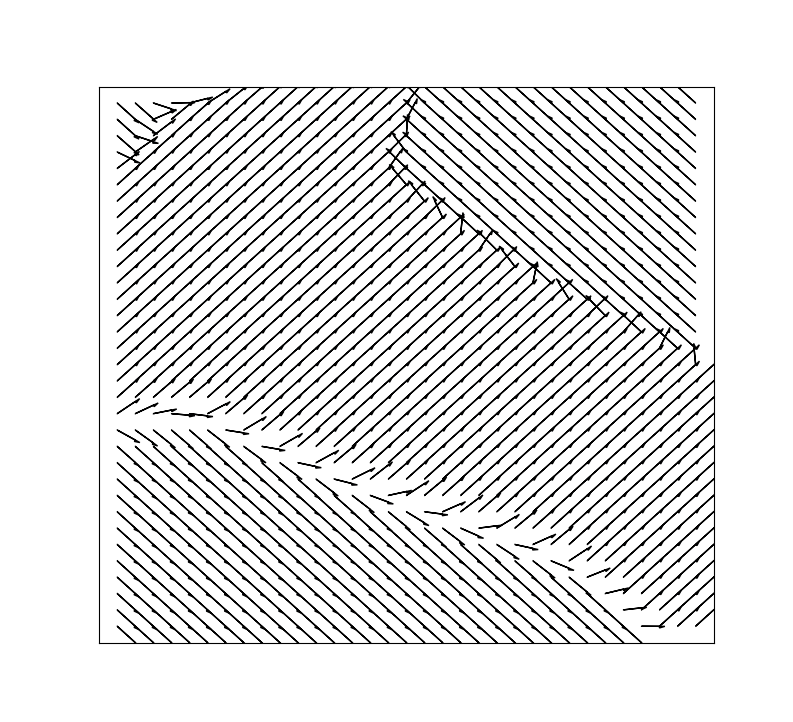

([], [])

In [165]:
# This section is used to visualize your learned policy
from torch import Tensor
output_i = np.zeros((33,33))
output_j = np.zeros((33,33))
output_i_m = np.zeros((33,33))
output_j_m = np.zeros((33,33))
value_ij = np.zeros((33,33))
for i in range(33):
    for j in range(33):
        states = Tensor(np.asarray([i,j])).float().unsqueeze(0)
        
        '''
        you need to revise the following line, 
        to fit your policy/network outputs
        '''
        action = policy.select_action(states)
#         action, value = policy(states)
        output_i[i,j] = action[0]
        output_j[i,j] = action[1]
        value_ij[i,j] = value
        
plt.figure(figsize= (5,5))
for i in range(33):
    for j in range(33):
        plt.arrow(j,-i,output_j[i,j],-output_i[i,j],head_width=0.2,shape='left')
xlim(-1,33)
ylim(-33,1)
yticks([2*i-32 for i in range(17)],[2*i for i in range(17)])
plt.xticks([])
plt.yticks([])

# DDPG-FourWayGridWorld

In [ ]:
# The following scripts run the DDPG algorithm.

alias = 'ddpg' # an alias of your experiment, used as a label
ENV_NAME = 'FourWayGridWorld'

import matplotlib.pyplot as plt
import numpy as np
import torch
import gym
import argparse
import os
import torch.nn.functional as F
import utils
import TD3
import DDPG

def eval_policy(policy, eval_episodes=10):
    eval_env = FourWayGridWorld(33)

    avg_reward = 0.
    for _ in range(eval_episodes):
        state, done = eval_env.reset(), False
        while not done:
            action = policy.select_action(np.array(state))
            state, reward, done = eval_env.step(action)
            avg_reward += reward

    avg_reward /= eval_episodes
    #print("---------------------------------------")
    #print(f"Evaluation over {eval_episodes} episodes: {avg_reward:.3f}")
    #print("---------------------------------------")
    return avg_reward

env = FourWayGridWorld(33)
torch.manual_seed(0)
np.random.seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
max_action = 1

args_policy_noise = 0.001
args_noise_clip = 0.5
args_policy_freq = 2
args_max_timesteps = 80000
args_expl_noise = 0.1
args_batch_size = 25
args_eval_freq = 1000
args_start_timesteps = 0

kwargs = {
    "state_dim": state_dim,
    "action_dim": action_dim,
    "max_action": max_action,
    "discount": 0.99,
    "tau": 0.005
}


args_policy = 'DDPG'

if args_policy == "TD3":
    # Target policy smoothing is scaled wrt the action scale
    kwargs["policy_noise"] = args_policy_noise * max_action
    kwargs["noise_clip"] = args_noise_clip * max_action
    kwargs["policy_freq"] = args_policy_freq
    policy = TD3.TD3(**kwargs)
elif args_policy == "DDPG":
    policy = DDPG.DDPG(**kwargs)
replay_buffer = utils.ReplayBuffer(state_dim, action_dim)

# Evaluate untrained policy
evaluations = [eval_policy(policy)]

state, done = env.reset(), False
episode_reward = 0
episode_timesteps = 0
episode_num = 0
counter = 0
msk_list = []        
temp_curve = [eval_policy(policy)]
temp_val = []
for t in range(int(args_max_timesteps)):
    episode_timesteps += 1
    counter += 1
    # Select action randomly or according to policy
    if t < args_start_timesteps:
        action = np.random.uniform(-max_action,max_action,action_dim)
    else:
        # ϵ−greedy strategy 
        if np.random.uniform(0,1) < 0.1:
            action = np.random.uniform(-max_action,max_action,action_dim)
        else:
            action = (
                policy.select_action(np.array(state))
                + np.random.normal(0, max_action * args_expl_noise, size=action_dim)
            ).clip(-max_action, max_action)

    # Perform action
    next_state, reward, done = env.step(action) 
    done_bool = float(done) if episode_timesteps < 2*env.N else 0

    replay_buffer.add(state, action, next_state, reward, done_bool)

    state = next_state
    episode_reward += reward

    if t >= args_start_timesteps:
        '''TD3'''
        last_val = 999.
        patient = 5
        for i in range(1):
            policy.train(replay_buffer, args_batch_size)
                

    # Train agent after collecting sufficient data
    if done: 
        print(f"Total T: {t+1} Episode Num: {episode_num+1} Episode T: {episode_timesteps} Reward: {episode_reward:.3f}")
        msk_list = []
        state, done = env.reset(), False
        episode_reward = 0
        episode_timesteps = 0
        episode_num += 1 

    # Evaluate episode
    if (t + 1) % args_eval_freq == 0:
        evaluations.append(eval_policy(policy))
        print('recent Evaluation:',evaluations[-1])
        np.save('results/FourWayGridWorld_evaluations_alias{}_ENV{}'.format(alias,ENV_NAME),evaluations)

Total T: 46 Episode Num: 1 Episode T: 46 Reward: 5.500
Total T: 112 Episode Num: 2 Episode T: 66 Reward: -6.600
Total T: 125 Episode Num: 3 Episode T: 13 Reward: 8.800
Total T: 191 Episode Num: 4 Episode T: 66 Reward: -6.600
Total T: 257 Episode Num: 5 Episode T: 66 Reward: -6.600
Total T: 323 Episode Num: 6 Episode T: 66 Reward: -6.600
Total T: 389 Episode Num: 7 Episode T: 66 Reward: -6.600
Total T: 455 Episode Num: 8 Episode T: 66 Reward: -6.600
Total T: 463 Episode Num: 9 Episode T: 8 Reward: 9.300
Total T: 529 Episode Num: 10 Episode T: 66 Reward: -6.600
Total T: 595 Episode Num: 11 Episode T: 66 Reward: -6.600
Total T: 601 Episode Num: 12 Episode T: 6 Reward: 9.500
Total T: 667 Episode Num: 13 Episode T: 66 Reward: -6.600
Total T: 733 Episode Num: 14 Episode T: 66 Reward: -6.600
Total T: 799 Episode Num: 15 Episode T: 66 Reward: -6.600
Total T: 865 Episode Num: 16 Episode T: 66 Reward: -6.600
Total T: 873 Episode Num: 17 Episode T: 8 Reward: 9.300
Total T: 939 Episode Num: 18 Epi

Total T: 7074 Episode Num: 138 Episode T: 66 Reward: -6.600
Total T: 7140 Episode Num: 139 Episode T: 66 Reward: -6.600
Total T: 7206 Episode Num: 140 Episode T: 66 Reward: -6.600
Total T: 7220 Episode Num: 141 Episode T: 14 Reward: 8.700
Total T: 7286 Episode Num: 142 Episode T: 66 Reward: -6.600
Total T: 7352 Episode Num: 143 Episode T: 66 Reward: -6.600
Total T: 7418 Episode Num: 144 Episode T: 66 Reward: -6.600
Total T: 7484 Episode Num: 145 Episode T: 66 Reward: -6.600
Total T: 7550 Episode Num: 146 Episode T: 66 Reward: -6.600
Total T: 7616 Episode Num: 147 Episode T: 66 Reward: -6.600
Total T: 7682 Episode Num: 148 Episode T: 66 Reward: -6.600
Total T: 7700 Episode Num: 149 Episode T: 18 Reward: 8.300
Total T: 7716 Episode Num: 150 Episode T: 16 Reward: 8.500
Total T: 7727 Episode Num: 151 Episode T: 11 Reward: 9.000
Total T: 7740 Episode Num: 152 Episode T: 13 Reward: 8.800
Total T: 7806 Episode Num: 153 Episode T: 66 Reward: -6.600
Total T: 7872 Episode Num: 154 Episode T: 66 

Total T: 13341 Episode Num: 273 Episode T: 66 Reward: -6.600
Total T: 13407 Episode Num: 274 Episode T: 66 Reward: -6.600
Total T: 13473 Episode Num: 275 Episode T: 66 Reward: -6.600
Total T: 13539 Episode Num: 276 Episode T: 66 Reward: -6.600
Total T: 13605 Episode Num: 277 Episode T: 66 Reward: -6.600
Total T: 13671 Episode Num: 278 Episode T: 66 Reward: -6.600
Total T: 13686 Episode Num: 279 Episode T: 15 Reward: 8.600
Total T: 13752 Episode Num: 280 Episode T: 66 Reward: -6.600
Total T: 13770 Episode Num: 281 Episode T: 18 Reward: 8.300
Total T: 13836 Episode Num: 282 Episode T: 66 Reward: -6.600
Total T: 13856 Episode Num: 283 Episode T: 20 Reward: 8.100
Total T: 13922 Episode Num: 284 Episode T: 66 Reward: -6.600
Total T: 13988 Episode Num: 285 Episode T: 66 Reward: -6.600
Total T: 13993 Episode Num: 286 Episode T: 5 Reward: 9.600
recent Evaluation: -1.929999999999993
Total T: 14059 Episode Num: 287 Episode T: 66 Reward: -6.600
Total T: 14125 Episode Num: 288 Episode T: 66 Reward

Total T: 20352 Episode Num: 404 Episode T: 66 Reward: -6.600
Total T: 20418 Episode Num: 405 Episode T: 66 Reward: -6.600
Total T: 20484 Episode Num: 406 Episode T: 66 Reward: -6.600
Total T: 20550 Episode Num: 407 Episode T: 66 Reward: -6.600
Total T: 20616 Episode Num: 408 Episode T: 66 Reward: -6.600
Total T: 20682 Episode Num: 409 Episode T: 66 Reward: -6.600
Total T: 20748 Episode Num: 410 Episode T: 66 Reward: -6.600
Total T: 20814 Episode Num: 411 Episode T: 66 Reward: -6.600
Total T: 20880 Episode Num: 412 Episode T: 66 Reward: -6.600
Total T: 20946 Episode Num: 413 Episode T: 66 Reward: -6.600
recent Evaluation: -6.600000000000053
Total T: 21012 Episode Num: 414 Episode T: 66 Reward: -6.600
Total T: 21078 Episode Num: 415 Episode T: 66 Reward: -6.600
Total T: 21144 Episode Num: 416 Episode T: 66 Reward: -6.600
Total T: 21210 Episode Num: 417 Episode T: 66 Reward: -6.600
Total T: 21276 Episode Num: 418 Episode T: 66 Reward: -6.600
Total T: 21342 Episode Num: 419 Episode T: 66 R

Total T: 28262 Episode Num: 534 Episode T: 66 Reward: -6.600
Total T: 28274 Episode Num: 535 Episode T: 12 Reward: 8.900
Total T: 28289 Episode Num: 536 Episode T: 15 Reward: 8.600
Total T: 28355 Episode Num: 537 Episode T: 66 Reward: -6.600
Total T: 28421 Episode Num: 538 Episode T: 66 Reward: -6.600
Total T: 28487 Episode Num: 539 Episode T: 66 Reward: -6.600
Total T: 28553 Episode Num: 540 Episode T: 66 Reward: -6.600
Total T: 28619 Episode Num: 541 Episode T: 66 Reward: -6.600
Total T: 28685 Episode Num: 542 Episode T: 66 Reward: -6.600
Total T: 28689 Episode Num: 543 Episode T: 4 Reward: 9.700
Total T: 28755 Episode Num: 544 Episode T: 66 Reward: -6.600
Total T: 28763 Episode Num: 545 Episode T: 8 Reward: 9.300
Total T: 28771 Episode Num: 546 Episode T: 8 Reward: 9.300
Total T: 28837 Episode Num: 547 Episode T: 66 Reward: -6.600
Total T: 28903 Episode Num: 548 Episode T: 66 Reward: -6.600
Total T: 28969 Episode Num: 549 Episode T: 66 Reward: -6.600
recent Evaluation: -5.0500000000

recent Evaluation: -6.600000000000053
Total T: 36055 Episode Num: 665 Episode T: 66 Reward: -6.600
Total T: 36121 Episode Num: 666 Episode T: 66 Reward: -6.600
Total T: 36187 Episode Num: 667 Episode T: 66 Reward: -6.600
Total T: 36253 Episode Num: 668 Episode T: 66 Reward: -6.600
Total T: 36319 Episode Num: 669 Episode T: 66 Reward: -6.600
Total T: 36385 Episode Num: 670 Episode T: 66 Reward: -6.600
Total T: 36451 Episode Num: 671 Episode T: 66 Reward: -6.600
Total T: 36517 Episode Num: 672 Episode T: 66 Reward: -6.600
Total T: 36583 Episode Num: 673 Episode T: 66 Reward: -6.600
Total T: 36649 Episode Num: 674 Episode T: 66 Reward: -6.600
Total T: 36665 Episode Num: 675 Episode T: 16 Reward: 8.500
Total T: 36731 Episode Num: 676 Episode T: 66 Reward: -6.600
Total T: 36797 Episode Num: 677 Episode T: 66 Reward: -6.600
Total T: 36863 Episode Num: 678 Episode T: 66 Reward: -6.600
Total T: 36929 Episode Num: 679 Episode T: 66 Reward: -6.600
Total T: 36995 Episode Num: 680 Episode T: 66 Re

In [ ]:
# This section is used to visualize your learned policy
from torch import Tensor
output_i = np.zeros((33,33))
output_j = np.zeros((33,33))
output_i_m = np.zeros((33,33))
output_j_m = np.zeros((33,33))
value_ij = np.zeros((33,33))
for i in range(33):
    for j in range(33):
        states = Tensor(np.asarray([i,j])).float().unsqueeze(0)
        
        '''
        you need to revise the following line, 
        to fit your policy/network outputs
        '''
        action = policy.select_action(states)
#         action, value = policy(states)
        output_i[i,j] = action[0]
        output_j[i,j] = action[1]
        value_ij[i,j] = value
        
plt.figure(figsize= (5,5))
for i in range(33):
    for j in range(33):
        plt.arrow(j,-i,output_j[i,j],-output_i[i,j],head_width=0.2,shape='left')
xlim(-1,33)
ylim(-33,1)
yticks([2*i-32 for i in range(17)],[2*i for i in range(17)])
plt.xticks([])
plt.yticks([])